# Data Anlysis

## Importing librairies

In [1]:
import pickle
import os 
import json
import string
import requests
from IPython.display import clear_output

In [2]:
!pip install langdetect
!pip install names-dataset
!pip install bertopic
!pip install Wikidata
!pip install wordcloud
!pip install pyLDAvis
!pip install NRCLex
!pip install scikit-posthocs
!pip install empath
!pip install -U kaleido
clear_output()

In [3]:
#EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from datetime import datetime
from wikidata.client import Client
from tqdm import tqdm
from collections import Counter

#Preprocessing
from langdetect import detect
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from names_dataset import NameDataset
from itertools import chain 
import seaborn as sns

#Stats
import scipy.stats as stats
from scipy.stats import kruskal
import scikit_posthocs as sp
from scipy.stats import linregress
import statsmodels.formula.api as smf
from scipy.stats import f_oneway

#LDA
from gensim.models import Phrases
from gensim import corpora
from gensim import models

#WordCloud 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

#Topic visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

#BERTopic
from bertopic import BERTopic

#Targeted topics
from empath import Empath
import matplotlib.ticker as ticker

#Sentiment analysis
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [4]:
from tqdm import tqdm_notebook
from tqdm import tqdm
tqdm.pandas()
clear_output()

In [5]:
from nltk import download
download('averaged_perceptron_tagger')
download('wordnet')
download('omw-1.4')
download('punkt')
download('stopwords')
clear_output()

## References

[[1]](http://www.cs.cmu.edu/~ark/personas/) CMU Movie Summary Corpus webpage  
[[2]](http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf) _Learning Latent Personas of Film Characters_, David Bamman, Brendan O'Connor and Noah A. Smith, ACL 2013, Sofia, Bulgaria, August 2013 \
[[3]](https://www.nltk.org/) NLKT documentation 

# Table of contents
### [1. Extracted Topics](#1)

&nbsp;&nbsp;&nbsp;**[1.1 The topics](#1.1)**

&nbsp;&nbsp;&nbsp;**[1.2 Topics over time](#1.2)**

### [2. Concerns ](#2)

&nbsp;&nbsp;&nbsp;**[2.1 Categories across movies](#2.1)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.1 Percentage of movies](#2.1.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.2 Categories distribution](#2.1.2)

&nbsp;&nbsp;&nbsp;**[2.2 Categories over time](#2.2)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.1 Every year](#2.3.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.2 Every five years](#2.3.2)

### [3. Sentiments](#3)

&nbsp;&nbsp;&nbsp;**[3.1 The sentiments](#3.1)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.1 Plot sentiment analysis](#3.1.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.2 Plot multi-sentiments](#3.1.2)

&nbsp;&nbsp;&nbsp;**[3.2 Sentiments over time](#3.2)**


### [4. Combined](#4)

&nbsp;&nbsp;&nbsp;**[4.1 Topics and sentiments](#4.1)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1.1 Topics and sentiments association](#4.1.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1.2 Topics and sentiments over time](#4.1.2)

&nbsp;&nbsp;&nbsp;**[4.2 Topics and concerns](#4.2)**

&nbsp;&nbsp;&nbsp;**[4.2 Sentiments and concerns](#4.3)**

### [5. Statistical analysis](#5)

&nbsp;&nbsp;&nbsp;**[5.1 Over time](#5.1)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.1.1 Topics over time](#5.1.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.1.2 Sentiments over time](#5.1.2)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.1.2.1 Compound](#5.1.2.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.1.2.2 All sentiments](#5.1.2.2)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.1.3 Concern categories over time](#5.1.3)

&nbsp;&nbsp;&nbsp;**[5.2 Overall](#5.2)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2.1 Sentiments](#5.2.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2.1.1 During the whole period](#5.2.1.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2.1.2 During t1](#5.2.1.2)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2.1.3 During t2](#5.2.1.3)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2.1.4 During t3](#5.2.1.4)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2.2 Concern categories](#5.2.2)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2.2.1 During the whole period](#5.2.2.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2.2.2 During t1](#5.2.2.2)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2.2.3 During t2](#5.2.2.3)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2.2.4 During t3](#5.2.2.4)


&nbsp;&nbsp;&nbsp;**[5.3 Sentiments and topics](#5.3)**\
&nbsp;&nbsp;&nbsp;**[5.4 Sentiments and concerns](#5.4)**

## Context

All the preprocessing and data preparation have been done in `EDA_Preprocess_Models.ipynb`. In this notebook, we will focus on the analysis of the information we obtained.

In [6]:
#Loading our complete dataset
movies = pd.read_pickle('data/movies_aug_BERT_SA_Concern.pkl')

In [7]:
movies.head()

,WikiMovieID,FreeMovieID,Title,ReleaseDate,Revenue,Runtime,Languages,Countries,Genres,Plot,...,ecological_concern,health_concern,conflict_concern,technological_concern,space_concern,gender_inequality_concern,homophobia_concern,racism_concern,mental_concern,relationships_concern
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",...,0.0,0.0,0.004484,0.0,0.013453,0.0,0.0,0.0,0.0,0.004484
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,...,0.0,0.0,0.000000,0.0,0.003257,0.0,0.0,0.0,0.0,0.003257
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...",...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns...",...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a...",...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.030928


In [8]:
# Length of our dataset
print('We have {} data points.'.format(len(movies)))

We have 42178 data points.


In [9]:
# Most represented countries
print('Country representation:')
movies['Countries'].value_counts()[:6]

Country representation:


[United States of America]    17773
[India]                        4620
[]                             3307
[United Kingdom]               2284
[Japan]                        1157
[France]                        847
Name: Countries, dtype: int64

# 1. Extracted Topics <a id='1'></a>

## 1.1 The topics <a id='1.1'></a>

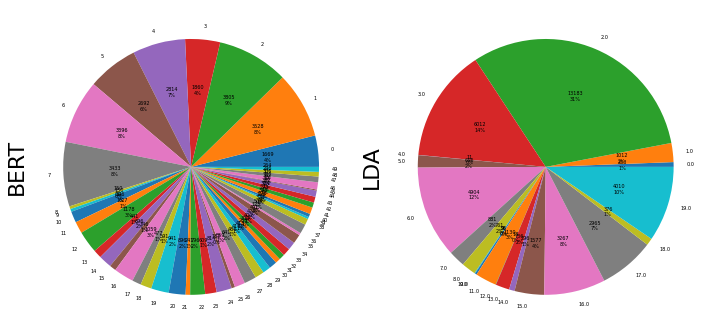

In [10]:
def label_function(val):
    return f'{val / 100 * len(movies):.0f}\n{val:.0f}%'

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
movies[movies.BERT!=-1].groupby('BERT').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 5}, ax=ax1)
movies.groupby('Topic').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 5}, ax=ax2)
ax1.set_ylabel('BERT', size=22)
ax2.set_ylabel('LDA', size=22)
plt.tight_layout()
plt.show()

What we can see from the following plot is the following : There are much more specific BERT topics than LDA ones. This is because as we have seen in our exploratory data analysis BERT is able to detect much more specific topics (such as cold war and nazi germany) in contrast with LDA (war movies in general). The downside of this property is that BERT is able to assign a topic to much less movies (about $\frac{1}{5}$) than LDA.

In [11]:
#Dataset creation for flourish plot

#Read data cotaining words belonging to each Bert topics
topic_words_dict = pd.read_pickle('data/words_per_topic.pkl')

#Select top 20 most frequent topics
topics_BERT_20 = movies["BERT"].value_counts(dropna=False) 
topics_BERT_20 = topics_BERT_20[topics_BERT_20>130].index.tolist()
topics_BERT_20.remove(-1) #-1 corresponds to unclassified movies

topic_words = pd.DataFrame()
rep = movies.groupby(['BERT']).size()

for topic in topics_BERT_20:
    for nb in range(0,10):
        new_row = {'Words':topic_words_dict[topic][nb][0], 'Word_score':topic_words_dict[topic][nb][1], 'Topic':topic, 'Topic_rep':rep[topic]}
        topic_words = topic_words.append(new_row, ignore_index=True)
clear_output()

In [12]:
topic_words["Combined_rep"]=topic_words["Word_score"]*topic_words["Topic_rep"]
topic_words
#topic_words.to_excel("topic_words.xlsx")

,Words,Word_score,Topic,Topic_rep,Combined_rep
0,town,0.018665,2,837,15.622685
1,men,0.015630,2,837,13.082074
2,horse,0.014586,2,837,12.208367
3,ranch,0.014406,2,837,12.058218
4,sheriff,0.013382,2,837,11.200827
...,...,...,...,...,...
185,student,0.010063,10,131,1.318280
186,class,0.009874,10,131,1.293470
187,college,0.009601,10,131,1.257699
188,tells,0.009582,10,131,1.255214


### 1.1.2 With BERT <a id='1.1.2'></a>

Labels for the top 10 most common topics.

In [13]:
#bert_topics = model.generate_topic_labels()

bert_topics = pd.read_pickle('predictions/bert_topics.pkl')
bert_topics = pd.DataFrame(bert_topics, columns = ["Bert_Topic"])
bert_topics.head(10)

,Bert_Topic
0,-1_film_father_life
1,0_father_police_family
2,1_police_murder_detective
3,2_town_men_horse
4,3_mother_father_family
5,4_earth_planet_space
6,5_ship_island_captain
7,6_wong_kong_master
8,7_tokyo_conan_japan
9,8_tells_home_husband


Visualization of the data set with the BERT topics.

## 1.2 Topics over time<a id='1.2'></a>

In this section we will study how each topic evolved through time, mainly by counting the amount of movies produced for each topic. As a first step, we will create two extra columns in our dataset : 
- `year`: The year of the release date of the movie.
- `five_year_period`: The five year in which the movie was released. We define five year periods in the followin way : 1900-1904, 1905-1909, 1910-1914, etc.

In [14]:
movies["year"] = pd.to_datetime(movies.ReleaseDate, errors="coerce").dt.year
movies["five_year_period"] = movies.year//5*5

# A lot of the ReleaseDate are not filled in the initial dataset which leads to NaT (and eventually NaN) values when converting to datetime
movies_with_year = movies[~movies.year.isna()]
print("We could extract the year of the release date for {:.2f}% of the movies".format(len(movies_with_year)/len(movies)*100))

We could extract the year of the release date for 93.80% of the movies


Our first step is to visualize the number of movies for each topic per year. We perform this procedure twice, once for the LDA topics and once for the BERT ones : 

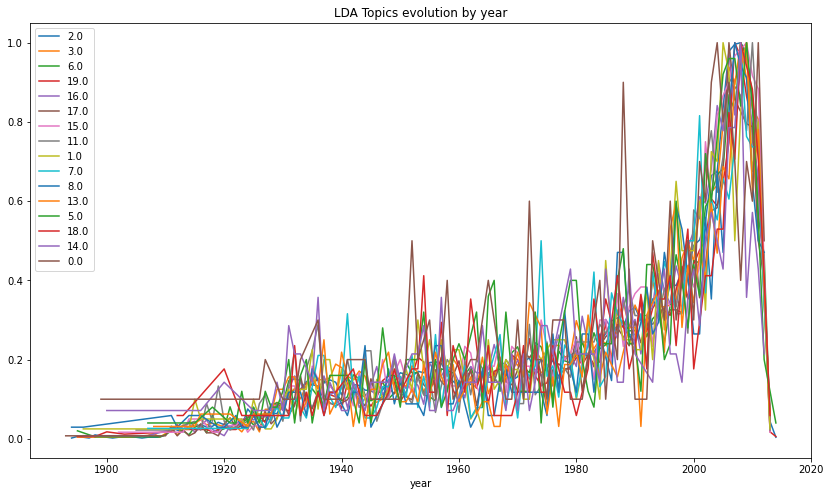

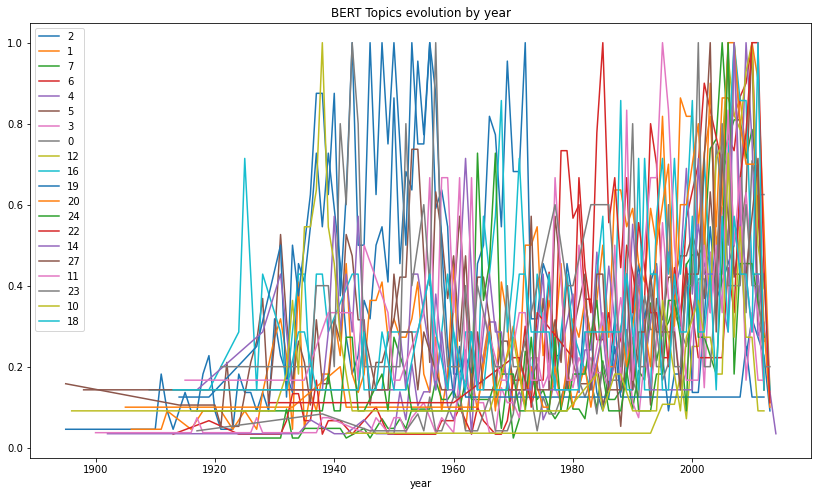

In [15]:
# Unique LDA topics with at least 100 movies assigned
topics_LDA = movies["Topic"].value_counts(dropna=True) 
topics_LDA = topics_LDA[topics_LDA>100].index.tolist()

fig = plt.figure(figsize=(14,8))
for topic in topics_LDA:
    temp = movies_with_year[movies_with_year.Topic==topic].groupby(["year"]).size()
    temp = temp/temp.max()   #should we divide by the movies_with_year.groupby(["year"]).size() ???
    fig = temp.plot(label=topic)
fig = plt.title("LDA Topics evolution by year")
fig = plt.legend()
fig = plt.show()

# List with 20 most frequent BERT topics
## -1 goes to unclassfied movies
topics_BERT = movies["BERT"].value_counts(dropna=False) 
topics_BERT = topics_BERT[1:21].index.tolist()


fig = plt.figure(figsize=(14,8))
for topic in topics_BERT:
    temp = movies_with_year[movies_with_year.BERT==topic].groupby(["year"]).size()
    temp = temp/temp.max()   
    fig = temp.plot(label=topic)
fig = plt.title("BERT Topics evolution by year")
fig = plt.legend()
fig = plt.show()

As we can see from the previous plots it is very hard to make sense of what is happening. We can see that both plots follow an exponential graph (BERT has much more noise) but our results are much too noisy at this point. In an effort to reduce some of this noise we perform the same graphs but this time instead of number of movies per year we use number of movies per five year period :

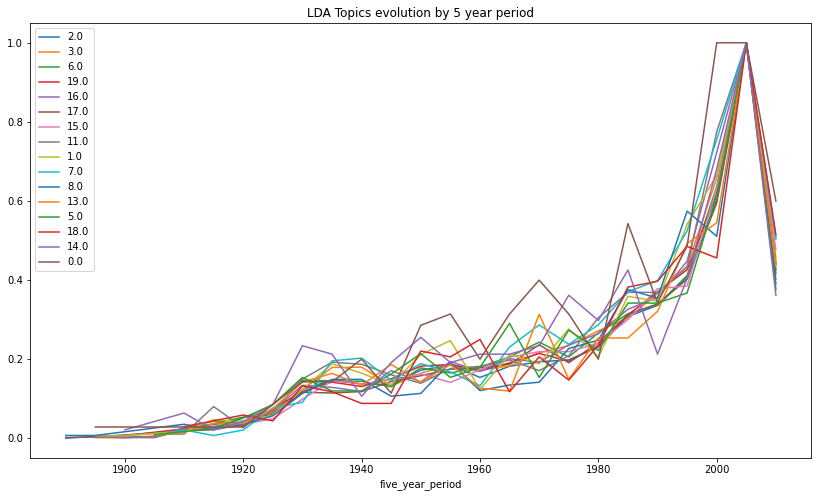

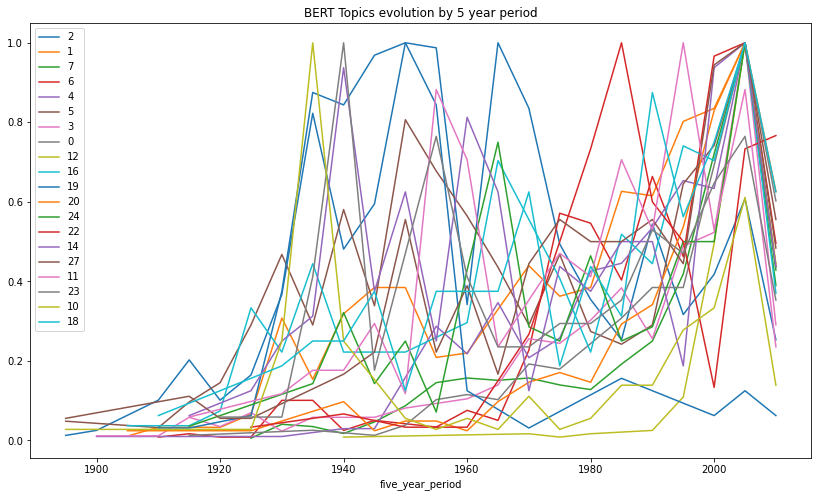

In [16]:
fig = plt.figure(figsize=(14,8))
for topic in topics_LDA:
    temp = movies_with_year[movies_with_year.Topic==topic].groupby(["five_year_period"]).size()
    temp = temp/temp.max()   
    fig = temp.plot(label=topic)
fig = plt.title("LDA Topics evolution by 5 year period")
fig = plt.legend()
fig = plt.show()

fig = plt.figure(figsize=(14,8)) 
for topic in topics_BERT:
    temp = movies_with_year[movies_with_year.BERT==topic].groupby(["five_year_period"]).size()
    temp = temp/temp.max()   
    fig = temp.plot(label=topic)
fig = plt.title("BERT Topics evolution by 5 year period")
fig = plt.legend()
fig = plt.show()

Even though a good amount of noise has been cleared out, it is still hard to draw convincing conclusions. As for the exponential property of our graphs this was something to be expected. That is because as we have seen from our data analysis performed for this project's milestone 2 (`EDA_Preprocess_models.ipynb`) the total number of movies keeps increasing per. This can be confirmed in the following plot. 

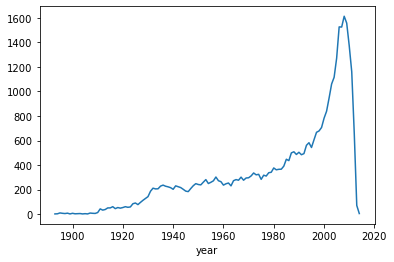

In [17]:
fig = movies.groupby(by="year").count()["WikiMovieID"].plot()

In an effort to tackle the `ReleaseDate` disproportionality in our dataset, instead of counting the amount of movies per year we will look at their proportions. As a result, in the following segments we present the percentage of movies associated with a certain topic per year and then five year period for LDA topics.

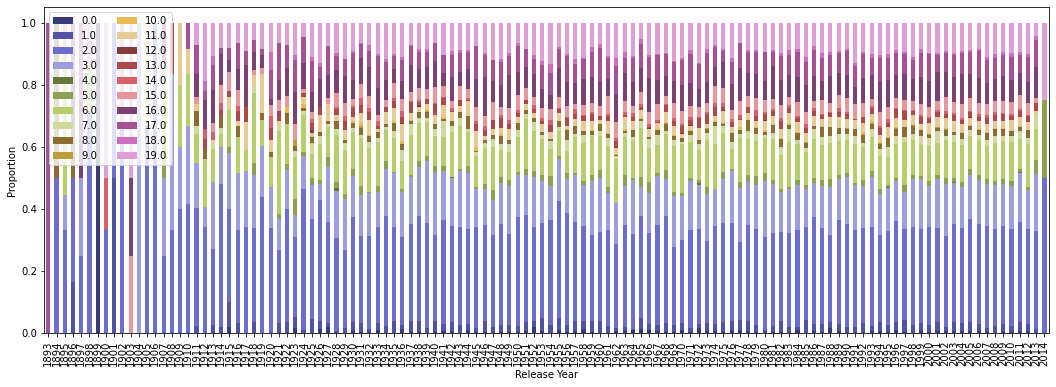

In [18]:
#Evolution over year LDA topics
cross_tab_prop = pd.crosstab(index=movies_with_year["year"].astype(int),
                             columns=movies_with_year["Topic"],
                             normalize="index")
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab20b', 
                    figsize=(18, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Release Year")
plt.ylabel("Proportion")
plt.show()

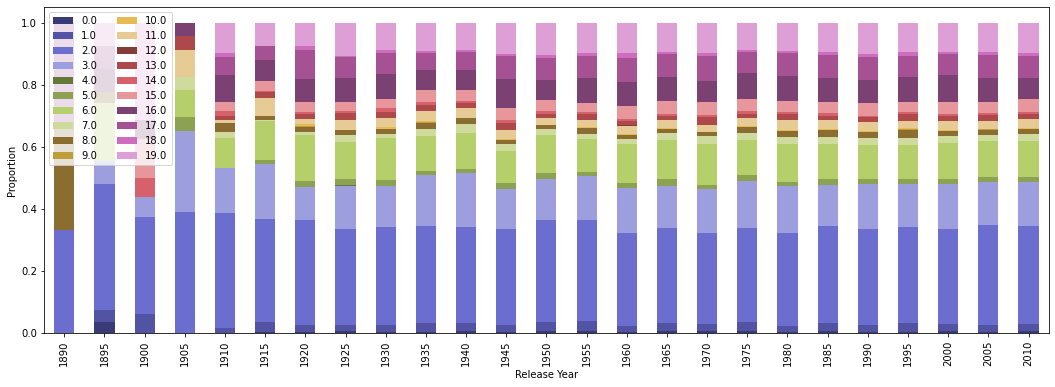

In [19]:
#Evolution over 5years LDA topics
cross_tab_prop = pd.crosstab(index=movies_with_year["five_year_period"].astype(int),
                             columns=movies_with_year["Topic"],
                             normalize="index")
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab20b', 
                    figsize=(18, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Release Year")
plt.ylabel("Proportion")
plt.show()

As we can see the proportion of each topic remains relatively similar along the years. However, due to lack of detail among the LDA topics we have decided to continue an analysis with only the BERT ones.

We proceed with producing the same plots for BERT topics but before (in order to be more visually clear) we add a column to our dataset `BERT_names` indicating the name for each topic. In this way, we can include the names of our topics as a legend in our plots.

In [20]:
BERT_movies_with_year = movies_with_year[movies_with_year['BERT'].isin(topics_BERT)].copy()
#Adding the names of the BERT topics into the data Frame (should we do it earlier)?
BERT_movies_with_year['BERT_names']=bert_topics.iloc[BERT_movies_with_year['BERT'].astype(int)+1].values
BERT_movies_with_year[["WikiMovieID","BERT", "BERT_names"]].head()

,WikiMovieID,BERT,BERT_names
0,975900,4,4_earth_planet_space
10,21926710,7,7_tokyo_conan_japan
21,25960460,3,3_mother_father_family
36,16686643,4,4_earth_planet_space
40,25413122,2,2_town_men_horse


In [21]:
# Creating our own color palette to use in the following plot

colors=[[0.22352941, 0.23137255, 0.4745098,  1.        ],
        [0.32156863, 0.32941176, 0.63921569, 1.        ],
        [0.61176471, 0.61960784, 0.87058824, 1.        ],
        [0.38823529, 0.4745098,  0.22352941, 1.        ],
        [0.54901961, 0.63529412, 0.32156863, 1.        ],
        [0.80784314, 0.85882353, 0.61176471, 1.        ],
        [0.54901961, 0.42745098, 0.19215686, 1.        ],
        [0.74117647, 0.61960784, 0.22352941, 1.        ],
        [0.90588235, 0.79607843, 0.58039216, 1.        ],
        [0.51764706, 0.23529412, 0.22352941, 1.        ],
        [0.67843137, 0.28627451, 0.29019608, 1.        ],
        [0.90588235, 0.58823529, 0.61176471, 1.        ],
        [0.48235294, 0.25490196, 0.45098039, 1.        ],
        [0.64705882, 0.31764706, 0.58039216, 1.        ],
        [0.19215686, 0.50980392, 0.74117647, 1.        ],
        [0.41960784, 0.68235294, 0.83921569, 1.        ],
        [0.90196078, 0.33333333, 0.05098039, 1.        ],
        [0.99215686, 0.55294118, 0.23529412, 1.        ],
        [0.19215686, 0.63921569, 0.32941176, 1.        ],
        [0.45490196, 0.76862745, 0.4627451 , 1.        ],
        [0.45882353, 0.41960784, 0.69411765, 1.        ],
        [0.61960784, 0.60392157, 0.78431373, 1.        ],
        [0.38823529, 0.38823529, 0.38823529, 1.        ],
        [0.58823529, 0.58823529, 0.58823529, 1.        ]]

colors_tab20b =  plt.cm.get_cmap('tab20b')
#print(colors_tab20b([0,1,3,4,5,7,8,9,11,12,13,15,16,17]))
colors_tab20c =  plt.cm.get_cmap('tab20c')
#print(colors_tab20c([0,1,4,5,8,9,12,13,16,17]))
#colors = np.vstack((colors_tab20b,colors_tab20c))
#print(colors)
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

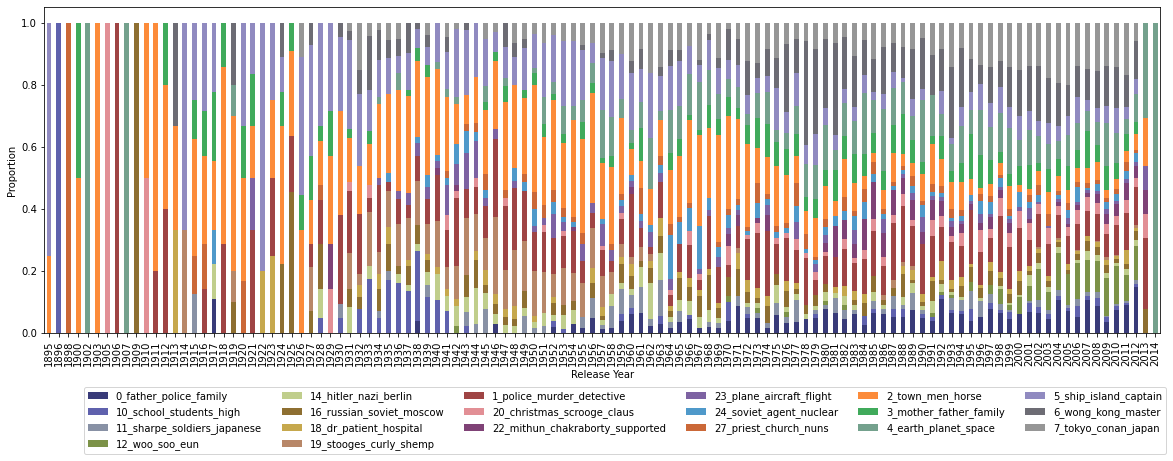

In [22]:
#Evolution over year BERT topics

cross_tab_prop = pd.crosstab(index=BERT_movies_with_year["year"].astype(int),
                             columns=BERT_movies_with_year["BERT_names"],
                             normalize="index")
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap=mymap, 
                    figsize=(20, 6))

plt.legend(ncol=6,bbox_to_anchor=(1.01, -0.15))
plt.xlabel("Release Year")
plt.ylabel("Proportion")
plt.show()

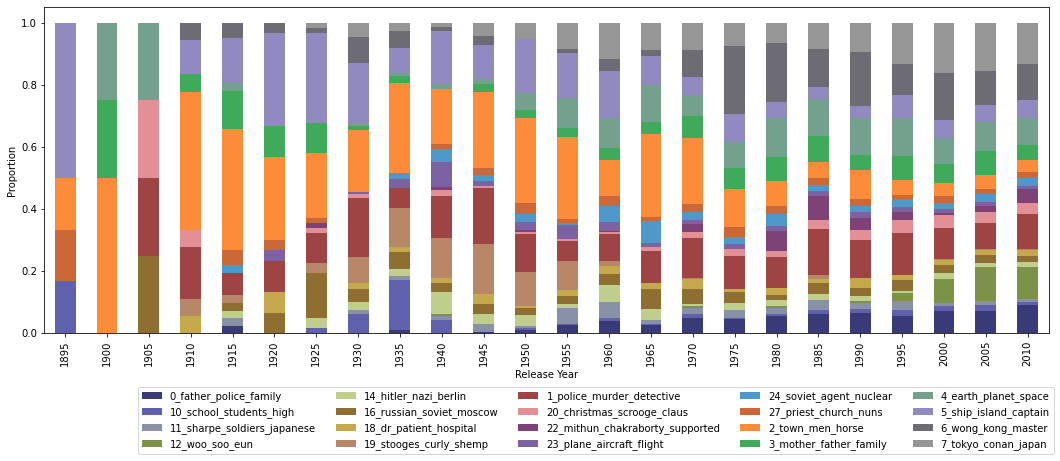

In [23]:
#evolution over 5yers BERT topics
cross_tab_prop = pd.crosstab(index=BERT_movies_with_year["five_year_period"].astype(int),
                             columns=BERT_movies_with_year["BERT_names"],
                             normalize="index")
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap=mymap, 
                    figsize=(18, 6))

plt.legend(ncol=5,bbox_to_anchor=(1.01, -0.15)) #ncol=1,bbox_to_anchor=(1.01, 1.0))
plt.xlabel("Release Year")
plt.ylabel("Proportion")
plt.show()

We can see once more that when plotting per year instead of five yeart period the plot is much less concice. Additionally, in order to make our final plot more interpretable we decided to create an interactive version of it : 

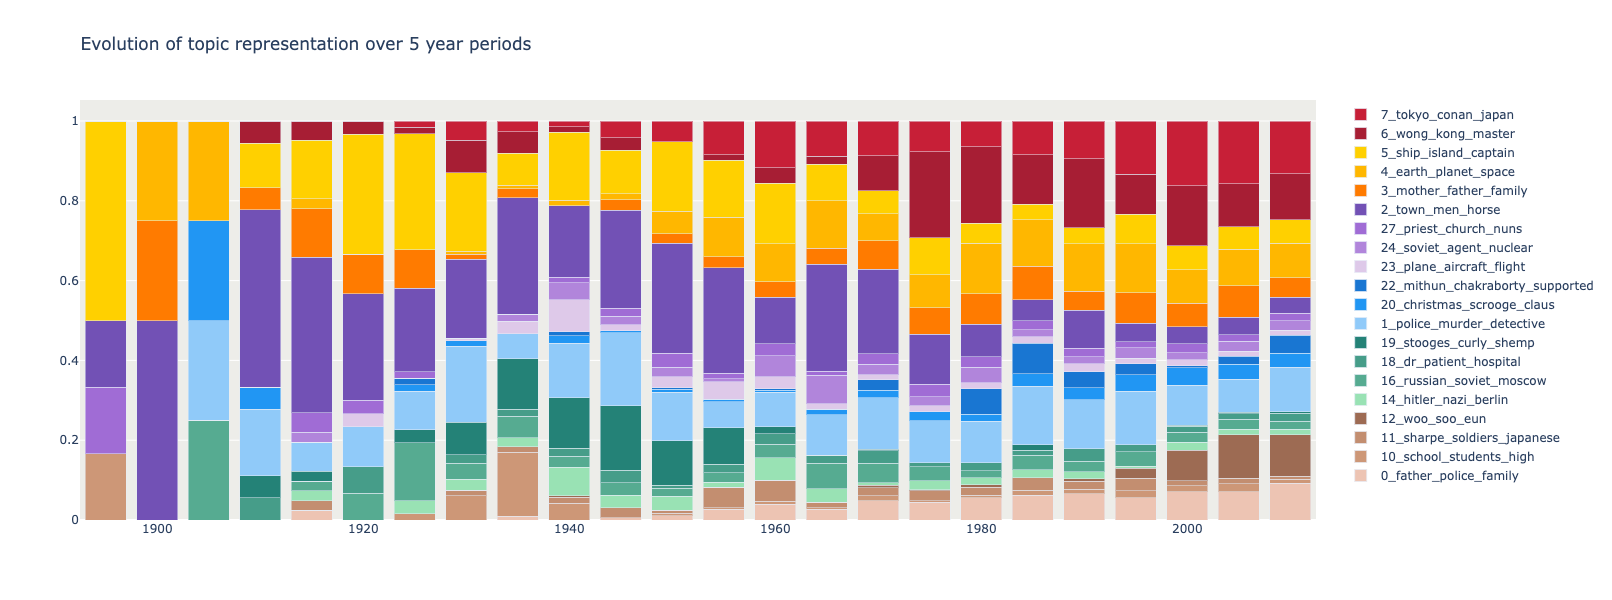

In [42]:
# Original colour palette leaving it here just in case it's needed elsewhere
                                                               # Shades of 
colours = ["DEC9E9", "C19EE0", "B185DB", "A06CD5", "7251B5", "6247AA",   #violet
           "99E2B4", "78C6A3", "56AB91", "469D89", "248277", "036666",   #green
           "FF7B00", "FF9500", "FFAA00", "FFB700", "FFD000", "FFEA00",   #yellow
           "641220", "85182A", "A71E34", "B21E35", "C71F37", "E01E37",   #red
           "E3F2FD", "90CAF9", "42A5F5", "2196F3", "1976D2", "0D47A1",   #blue
           "FF0A54", "FF5C8A", "FF85A1", "FF99AC", "F9BEC7", "FAE0E4",   #pink
           "EDC4B3", "DEAB90", "CD9777", "C38E70", "9D6B53", "774936"]   #brown

# Colors chosen for interactive plot
colours = ["EDC4B3", "DEAB90", "CD9777", "C38E70", "9D6B53", 
           "99E2B4", "78C6A3", "56AB91", "469D89", "248277", 
           "90CAF9", "42A5F5", "2196F3", "1976D2", 
           "DEC9E9", "C19EE0", "B185DB", "A06CD5", "7251B5", 
           "FF7B00", "FF9500", "FFB700", "FFD000",  
           "A71E34",  "C71F37", ]

colours = ["EDC4B3",  "CD9777", "C38E70", "9D6B53", 
           "99E2B4",  "56AB91", "469D89", "248277", 
           "90CAF9",  "2196F3", "1976D2", 
           "DEC9E9",  "B185DB", "A06CD5", "7251B5", 
           "FF7B00",  "FFB700", "FFD000",  
           "A71E34",  "C71F37", ]


colours = ["#"+colour for colour in colours]

# Same as before - Can be deleted if we keep all graphs 
cross_tab_prop = pd.crosstab(index=BERT_movies_with_year["five_year_period"].astype(int),
                             columns=BERT_movies_with_year["BERT_names"],
                             normalize="index")

plot_data = []
for i, x in enumerate(cross_tab_prop.columns):
    plot_data.append(go.Bar(name=str(x), x=cross_tab_prop.index, y=cross_tab_prop[x], marker_color = colours[i]))

figure = go.Figure(plot_data)
figure.update_layout(barmode = 'stack',
                     width = 900,
                     height = 600,
                     autosize = True,
                     title_text = "Evolution of topic representation over 5 year periods",
                     plot_bgcolor="#edede9",
                    )

figure.show()

figure.write_html("output/bert_topics_time.html")
figure.write_image("output/plotly_static/bert_topics_time.png")

You can enjoy all our interactive graphs on our [website](https://clararenou.github.io/Refl-action/) but in the meantime you can see a static version of it here :
![bert_topics_time!](output/plotly_static/bert_topics_time.png "bert_topics_time")

Analyzing our graph some interesting facts that we have noticed are the following : 
- Classic adventures downfall : After 1920's we can see the rapid decline of famous genres that in our current times are still considered as classics. This phenomenon can be seen through topic number 2 (town_men_horse) which is related to westerns. Additionally, the same can be seen for topic 5 (ship_island_captain) which depicts classical "Island adventures" based on books like "The mysterious island" and "Gulliver's Travels".
- War benefiting movie plots : Looking around periods of time where the war tensions were as high as ever, like the second world war (1939-1945) and the cold war phase within the cold war (1962-1979) we can see that some movie plots experienced a big surge during these times. Topics that reached a peak during those times (more than double the count of their average) are topic 14 (hitler_nazi_germany), topic 23 (plane_aircraft_flights) and topic 24 (soviet_agent_nuclear). All three of these plots reached their peak during the 1940-1945 (2nd world war) and the 1960-1965 (cuban missile crisis) year periods. Additionally, topic 24 has another peak in 1980-1985 which could be linked with the Reagan-Gorbachev meeting in 1985.
- International cinema late blooming : One more thing that we can take notice is that movies with interest in eastern culture display a rising trend since last century. This can be noticed through topics 7 (japanese films), 6 (kung fu films) and 12 (chinese films).

### 1.2.1 With LDA <a id='1.2.1'></a>

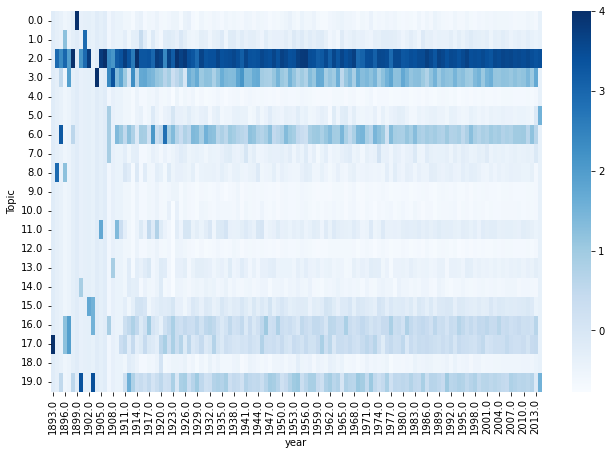

In [26]:
#Create a 2D table with topics as rows and years as columns
for_heatmap_LDA = movies_with_year.groupby(['year','Topic'])['WikiMovieID'].count().reset_index().sort_values(by='year')
for_heatmap_LDA = for_heatmap_LDA.pivot(columns = 'year', index='Topic', values= 'WikiMovieID').fillna(0)

#Row normalization
#cols = for_heatmap_LDA.columns
#for col in cols:
#    for_heatmap_LDA['{}_'.format(col)] = (for_heatmap_LDA[col] - for_heatmap_LDA.mean(axis=1) ) / for_heatmap_LDA.std(axis=1)
#cols_z = ['{}_'.format(col) for col in cols]

#Column normalization
for_heatmap_LDA = (for_heatmap_LDA - for_heatmap_LDA.mean()) / for_heatmap_LDA.std()

fig,ax=plt.subplots(figsize=(11,7))
#sns.heatmap(for_heatmap_LDA[cols_z], ax = ax, yticklabels=True, cmap="Blues", vmax = 5)
fig = sns.heatmap(for_heatmap_LDA, ax = ax, yticklabels=True, cmap="Blues", vmax = 4)

### 1.2.2 With BERT <a id='1.2.2'></a>

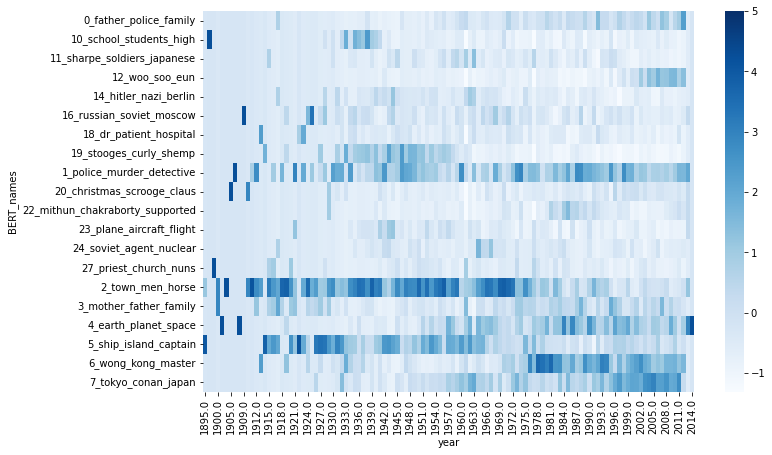

In [27]:
#Create a 2D table with topics as rows and years as columns
for_heatmap_BERT = BERT_movies_with_year.groupby(['year','BERT_names'])['WikiMovieID'].count().reset_index().sort_values(by='year')
for_heatmap_BERT = for_heatmap_BERT.pivot(columns = 'year', index='BERT_names', values= 'WikiMovieID').fillna(0)

#Column normalization
for_heatmap_BERT = (for_heatmap_BERT - for_heatmap_BERT.mean()) / for_heatmap_BERT.std()

fig,ax=plt.subplots(figsize=(11,7))
#sns.heatmap(for_heatmap_LDA[cols_z], ax = ax, yticklabels=True, cmap="Blues", vmax = 5)
fig = sns.heatmap(for_heatmap_BERT, ax = ax, yticklabels=True, cmap="Blues", vmax =5)

---

# 2. Concerns <a id='2'></a>

In `EDA_Preprocess_Models.ipynb` we created lexical categories for different concerns which may arise in the sociecy. Those concerns are  about:
- ecology, 
- health,
- war and conflicts,
- technologies,
- space,
- gender inequalities,
- homophobia,
- racism,
- mental state,
- human interactions and relationships.

In [28]:
concerns = ["ecological_concern", "health_concern", "conflict_concern", "technological_concern",
            "space_concern", "gender_inequality_concern", "homophobia_concern", "racism_concern",
            "mental_concern","relationships_concern"]

## 2.1 Across movies <a id='2.1'></a>

In this section, we look at how the concerns are represented across movies.

### 2.1.1 Percentage of movies <a id='2.1.1'></a>

First, the percentage of movies that are in a certain category is computed,
- first by counting all non-null entries in each category,
- then by restricting to only movies having a score greater than 0.01

In [29]:
def count_movies_concern(concern, threshold):
    count = np.sum(movies[concern].values>threshold)
    return count

In [30]:
# Percentage of non-zeros scores per concern
non_null = []
for concern in concerns :
    non_null.append(100 * count_movies_concern(concern, threshold=0) / len(movies))
# Percentage of scores higher than 0.01 per concern
high_score = []
for concern in concerns :
    high_score.append(100 * count_movies_concern(concern, threshold=0.01) / len(movies))

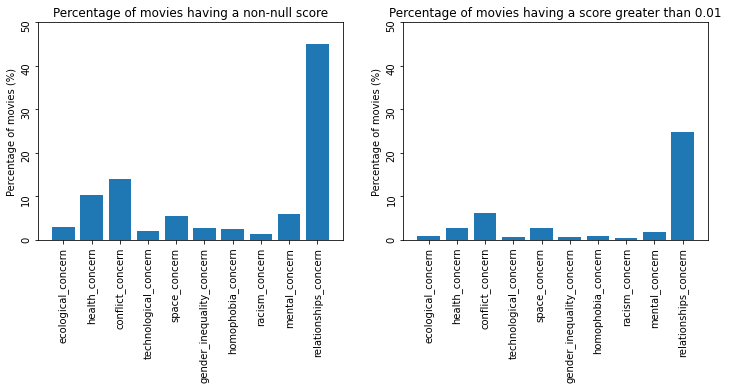

In [31]:
fig, axs = plt.subplots(1, 2, figsize = (12,4))
axs[0].bar(concerns, non_null)
axs[0].tick_params(labelrotation=90)
axs[0].set_ylim([0, 50])
axs[0].set_ylabel("Percentage of movies (%)")
axs[0].set_title("Percentage of movies having a non-null score")

axs[1].bar(concerns, high_score)
axs[1].tick_params(labelrotation=90)
axs[1].set_ylim([0, 50])
axs[1].set_ylabel("Percentage of movies (%)")
axs[1].set_title("Percentage of movies having a score greater than 0.01")
plt.show()

### 2.1.2 Concern distributions <a id='2.1.2'></a>

For each concern, the score distribution is plotted in logarithmic values.

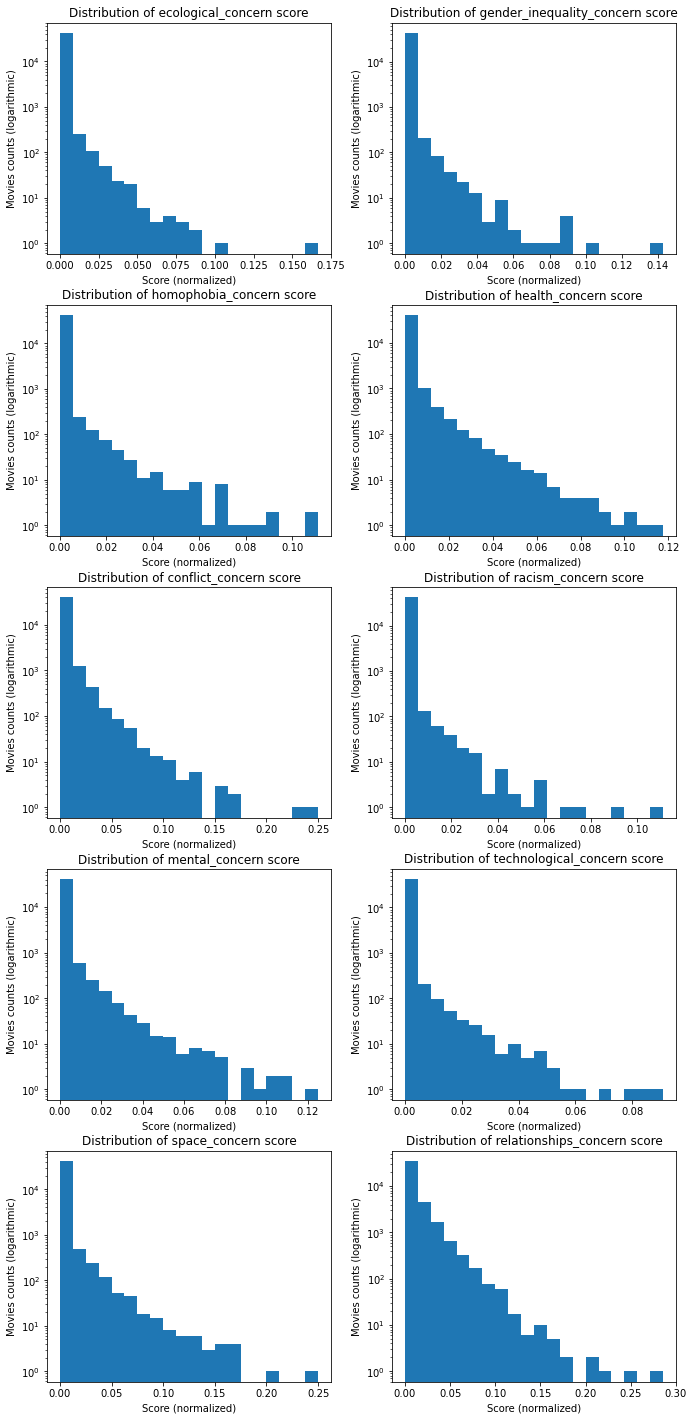

In [32]:
fig, axs = plt.subplots(5, 2, figsize=(10,20))
fig.tight_layout(pad=3)
ix, iy = 0, 0
for i, concern in enumerate(concerns):
    axs[i%5,i%2].hist(movies[concern], log=True, bins=20)
    axs[i%5,i%2].set_title('Distribution of ' + concern + ' score')
    axs[i%5,i%2].set_xlabel('Score (normalized)')
    axs[i%5,i%2].set_ylabel('Movies counts (logarithmic)')

plt.show()

## 2.2 Over time<a id='2.2'></a>

We are interested in how the concerns presence in movies evolve with time. First a visualization is done every year, then by groupping the time into periods of 5 years.

Set colors for visualizations

In [33]:
concern_color_dict={"ecological_concern":"#f94436", "health_concern":"#8c3214", "conflict_concern":"#f8d044",
                    "technological_concern":"#f28b0c", "space_concern":"#44c2f8", "gender_inequality_concern":"#6ab867",
                    "homophobia_concern":"#de489f", "racism_concern":"#489ede", "mental_concern":"#80807d",
                    "relationships_concern":"#adf763"}

Bootstrap method for confidence intervals:

In [34]:
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

### 2.2.1 Every year <a id='2.2.1'></a>

We are interested in categories evolution every year.

In [35]:
# Dictionary to store lower bounds and upper bounds for each concern. It has the following form :
# {"Lower_concern_X":List(lower_bounds_per_year), "Upper_concern_X":List(upper_bounds_per_year)} 
bootstrap_CIs_1year = {}

# Initiating the lists to store the lower and upper bounds for the 95% CI for each concern for each year
for concern in concerns:
    bootstrap_CIs_1year['Lower_{}'.format(concern)]=[]
    bootstrap_CIs_1year['Upper_{}'.format(concern)]=[]

# Computing the lower and upper bounds for the 95% CI for each concern
for group_name, group in movies_with_year.groupby("year"):
    for concern in concerns:
        bootstrap_CIs_1year['Lower_{}'.format(concern)].append(bootstrap_CI(group[concern],1000)[0])
        bootstrap_CIs_1year['Upper_{}'.format(concern)].append(bootstrap_CI(group[concern],1000)[1])

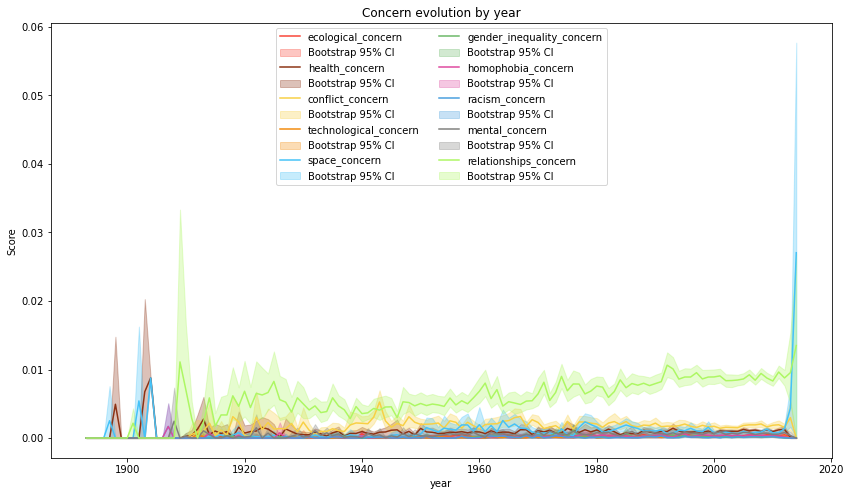

In [36]:
fig = plt.figure(figsize=(14,8))

for concern in concerns:
    temp = movies_with_year.groupby(["year"])[concern].mean()
    fig = temp.plot(label=concern, color=concern_color_dict[concern])
    fig = plt.fill_between(np.sort(movies_with_year["year"].unique()),
                           bootstrap_CIs_1year['Lower_{}'.format(concern)],
                           bootstrap_CIs_1year['Upper_{}'.format(concern)],
                           alpha = 0.3,
                           color=concern_color_dict[concern],label='Bootstrap 95% CI')
    
fig = plt.title("Concern evolution by year")
fig = plt.ylabel('Score')
fig = plt.legend(loc='upper center', ncol=2)
fig = plt.show()

### 2.2.2 Every five years <a id='2.2.2'></a>

In [37]:
# Dictionary to store lower bounds and upper bounds for each concern for each 5 year period (=5yp). It has the following form :
# {"Lower_concern_X":List(lower_bound_per_5yp), "Upper_concern_X":List(upper_bound_per_5yp)} 
bootstrap_CIs_5year = {}

# Initiating the lists to store the lower and upper bounds for the 95% CI for each concern for each five year period
for concern in concerns:
    bootstrap_CIs_5year['Lower_{}'.format(concern)]=[]
    bootstrap_CIs_5year['Upper_{}'.format(concern)]=[]
    
# Computing the lower and upper bounds for the 95% CI for each concern
for group_name, group in movies_with_year.groupby("five_year_period"):
    for concern in concerns:
        bootstrap_CIs_5year['Lower_{}'.format(concern)].append(bootstrap_CI(group[concern],1000)[0])
        bootstrap_CIs_5year['Upper_{}'.format(concern)].append(bootstrap_CI(group[concern],1000)[1])

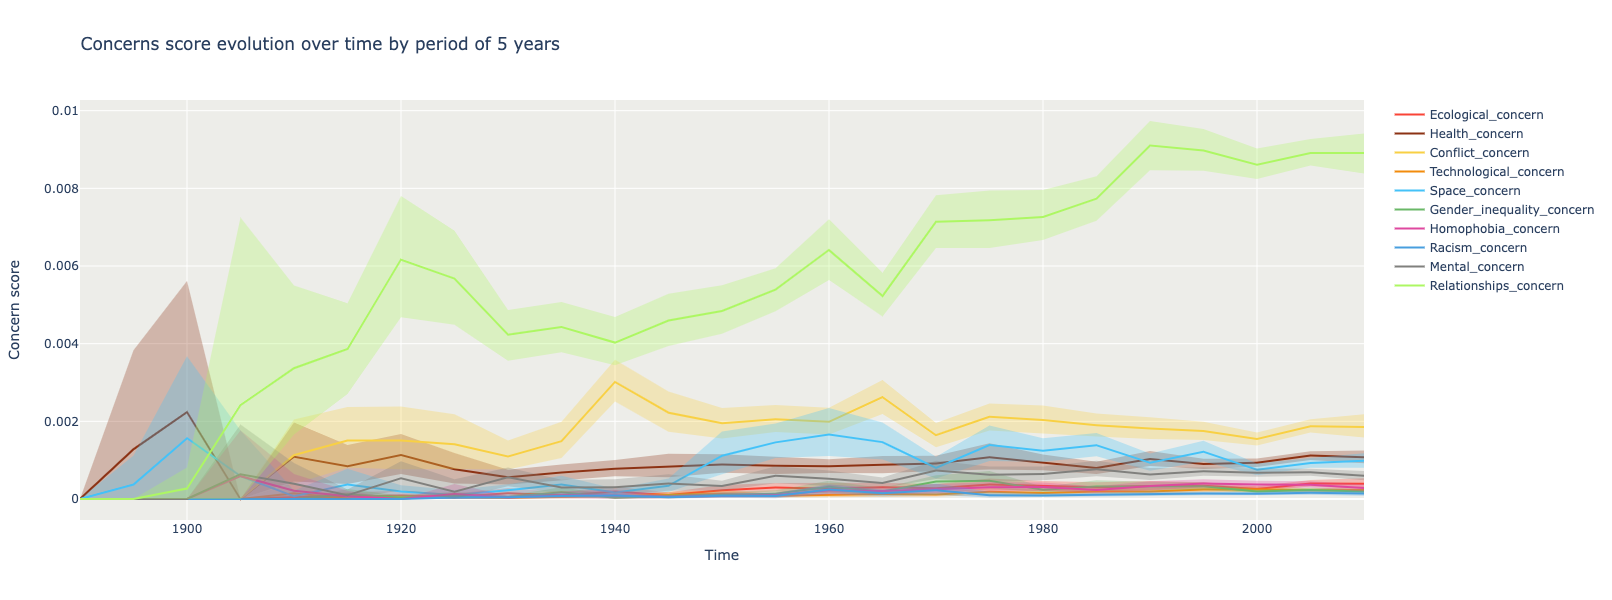

In [41]:
fig = make_subplots()
x = np.sort(movies_with_year["five_year_period"].unique()).tolist()

for concern in concerns:
    # Mean of category score over five year period 
    y = movies_with_year.groupby(["five_year_period"])[concern].mean().values
    # Bootstrap 95% CI
    y_lower = bootstrap_CIs_5year['Lower_{}'.format(concern)]
    y_upper = bootstrap_CIs_5year['Upper_{}'.format(concern)]
    
    # Trace for mean score
    trace_mean_score = go.Scatter(  x=x,
                                    y=y,
                                    line=dict(color=concern_color_dict[concern]),
                                    mode='lines',
                                    name=concern.capitalize()
                                 )
    # Tracce for CI
    trace_CI = go.Scatter(  x=x+x[::-1], 
                            y=y_upper+y_lower[::-1], 
                            fill='toself',
                            fillcolor=concern_color_dict[concern],
                            opacity=0.3,
                            line=dict(color='rgba(255,255,255,0)'),
                            hoverinfo="skip",
                            showlegend=False
                        )
    
    # Updating figure 
    fig.add_trace(trace_mean_score)
    fig.add_trace(trace_CI)

fig.update_layout(
    yaxis_title='Concern score',
    xaxis_title='Time',
    title='Concerns score evolution over time by period of 5 years',
    width=1000,
    height=600,
    plot_bgcolor="#edede9",
    hovermode="x unified"
)
fig.show()
fig.write_html("output/concern_score_time.html")
fig.write_image("output/plotly_static/concern_score_time.png")

You can enjoy all our interactive graphs on our [website](https://clararenou.github.io/Refl-action/) but in the meantime you can see a static version of it here :
![concern_score_time!](output/plotly_static/concern_score_time.png "concern_score_time")

## 2.3 Main words <a id='2.2.2'></a>

We want to output what words from each category are presents in the movies plot summaries.  
For this, we first assign a category to a movie based on its higher concern score.  
We then extract from the plot summaries the words matching to the main movie category, and finally concatenate those words in a single list for each category.  
A WordCloud is then used to display those words.  

In [43]:
"""
Giving to a movie the concern category for which it has the highest score
"""
def find_concern_cat(row):
    unique_categ = np.nan
    best_score = 0.
    for i, categ in enumerate(concerns):
        if row[i] > best_score:
            best_score = row[i]
            unique_categ = categ
    return unique_categ

movies["concern"] = movies[concerns].apply(lambda row: find_concern_cat(row), axis=1)

print("{:.2f} % movies have been attributed to a unique concern category".format(100*(~movies["concern"].isnull()).sum()/len(movies)))

60.45 % movies have been attributed to a unique concern category


In [44]:
lexicon = Empath()

# Creating a new dataset focused on concerns categories
cat_words=movies[["WikiMovieID", "FreeMovieID", "Title", "for_Empath","concern"]]
cat_words=cat_words[~cat_words.concern.isnull()]

# Finding which words are common between plot summaries and concerns categories
def words_in_cat(row):
    for c in concerns:
        if row[4] == c:
            return list(set(lexicon.cats[c]) & set(row[3]))
cat_words["words_cat"]=cat_words.apply(lambda row: words_in_cat(row), axis=1)
cat_words.head()

,WikiMovieID,FreeMovieID,Title,for_Empath,concern,words_cat
0,975900,/m/03vyhn,Ghosts of Mars,"[Set, second, half, century, film, depicts, Ma...",space_concern,"[Mars, planet, civilization]"
1,9363483,/m/0285_cd,White Of The Eye,"[series, murders, women, throughout, Arizona, ...",space_concern,[space]
4,6631279,/m/0gffwj,Little city,"[artist, works, cab, driver, side, hard, time,...",relationships_concern,"[relationship, friendship]"
6,18296435,/m/04cqrs4,Aaah Belinda,"[Serap, actress, strong, lively, personality, ...",relationships_concern,[family]
7,11250635,/m/02r52hc,The Mechanical Monsters,"[story, starts, one, robots, flies, scientist,...",ecological_concern,[scientists]


In [45]:
# For each category, joining every `words_cat` of the movies belonging to this category in a single list 
categ_dict = {key: [] for key in concerns}
for concern in concerns:
    for lw in (cat_words[cat_words.concern == concern].words_cat).array:
        categ_dict[concern] += lw

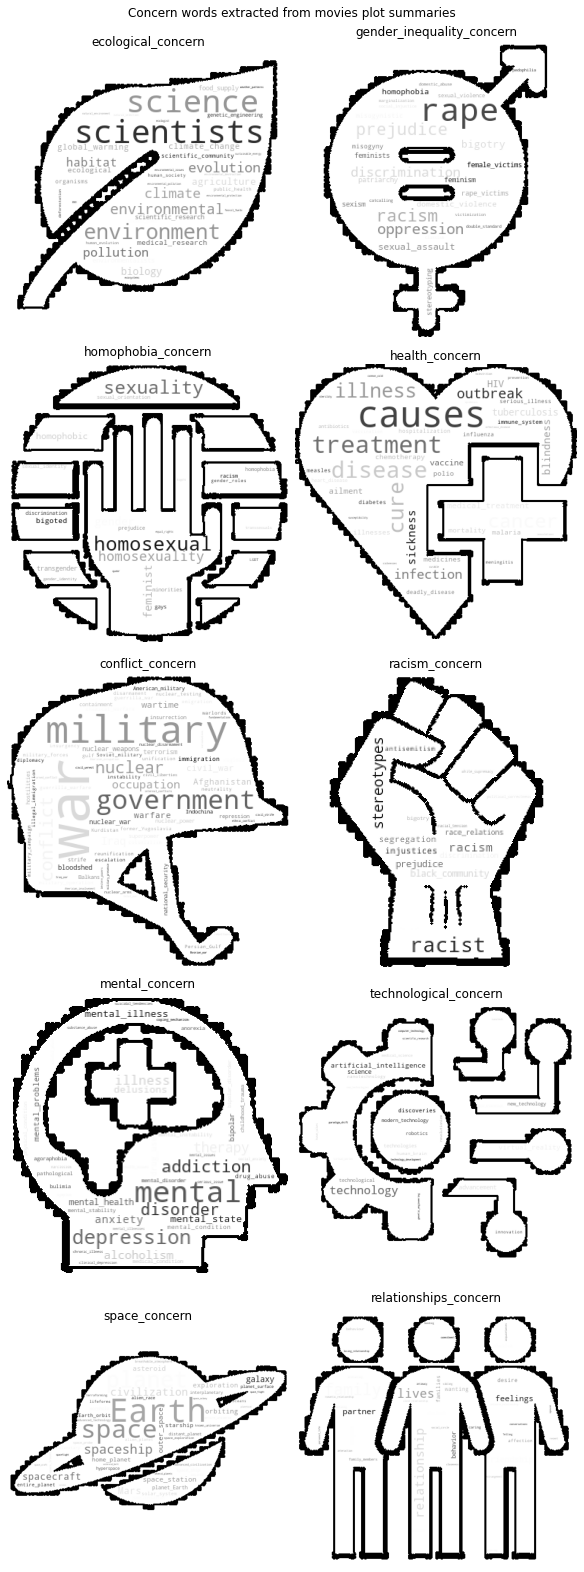

In [46]:
# WordCloud
fig, axs = plt.subplots(5, 2, figsize=(8,22), constrained_layout=True) 

# Mask images names
masks = ["ecology", "health", "war", "technology", "space", "egal", "homophobia", "racism", "mental", "relations"]

for i, c in enumerate(concerns):
    # Read mask image
    mask = np.array(Image.open("data/masks_wordclouds/"+masks[i]+".jpg"))

    # Create a Word Cloud image
    wc = WordCloud(background_color="white", mask=mask, collocations=False, 
                   contour_width=3, contour_color='black', colormap="binary",
                   height=400, width=400)

    # Generate a wordcloud
    wc.generate(' '.join(categ_dict[c]))

    # store to file
    wc.to_file("output/wordclouds/"+c+"_wc.png")
    
    axs[i%5, i%2].imshow(wc)
    axs[i%5, i%2].axis('off')
    axs[i%5, i%2].set_title(c)
fig.suptitle("Concern words extracted from movies plot summaries")
plt.show()

In [47]:
# Data for interactive Flourish bubble plot

# Counting each word presence and giving it a percentage
words_count = {key: [] for key in concerns}
for concern in concerns:
    words_count[concern] = {i:categ_dict[concern].count(i) for i in categ_dict[concern]}
for concern in concerns:
    words_count[concern].update({k : 100*words_count[concern][k]/sum(words_count[concern].values()) for k in words_count[concern].keys()})
# In each category, sort words by descending percentage order
for concern in concerns:
    words_count[concern] = dict(sorted(words_count[concern].items(), key=lambda item: item[1], reverse=True))

# Downloading csv for Flourish
concern_for_flourish = pd.DataFrame()
for concern in concerns:
    pairs = list(words_count[concern].items())
    for entry in range(0,10):
        new_row = {'Word':pairs[entry][0], 'Word_percentage':pairs[entry][1], 'Concern': concern}
        concern_for_flourish = concern_for_flourish.append(new_row, ignore_index=True)
clear_output()

---

# 3. Sentiments <a id='3'></a>

In this section we will perform a small sentiment analysis using the sentiment scores we have already computed.

## 3.1 The sentiments <a id='3.1'></a>

As a first step we will take a look into the score distribution for each sentiment.

### 3.1.1 Plot classic sentiment analysis <a id='3.1.1'></a>

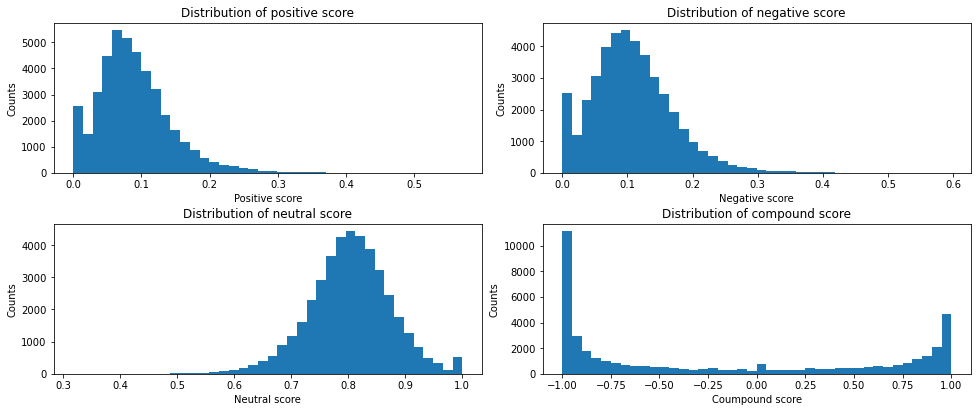

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(14,6))
fig.tight_layout(pad=3)
axs[0,0].hist(movies.positive_score,bins=40)
axs[0,0].set_title('Distribution of positive score')
axs[0,0].set_xlabel('Positive score')
axs[0,0].set_ylabel('Counts')

axs[0,1].hist(movies.negative_score,bins=40)
axs[0,1].set_title('Distribution of negative score')
axs[0,1].set_xlabel('Negative score')
axs[0,1].set_ylabel('Counts')

axs[1,0].hist(movies.neutral_score,bins=40)
axs[1,0].set_title('Distribution of neutral score')
axs[1,0].set_xlabel('Neutral score')
axs[1,0].set_ylabel('Counts')

axs[1,1].hist(movies.compound_score,bins=40)
axs[1,1].set_title('Distribution of compound score')
axs[1,1].set_xlabel('Coumpound score')
axs[1,1].set_ylabel('Counts')

plt.show()

What we can notice from this plot is the following : For the most part, the movie plots are dominated from a neutral feeling. We can see by the destributions of the positive and negative sentiments that most movies have a score of 0.1 and very few movies score above 0.15. However, what we found interesting from the compound score plot is that even that the movies have a very small score in either case there are about 2 times more movies that have a <ins>relatively</ins> high negative score than a positive one.

### 3.1.2 Plot multi-sentiments <a id='3.1.2'></a>

Emotional affects measured include the following:

- fear
- anger
- anticipation
- trust
- surprise
- positive
- negative
- sadness
- disgust
- joy

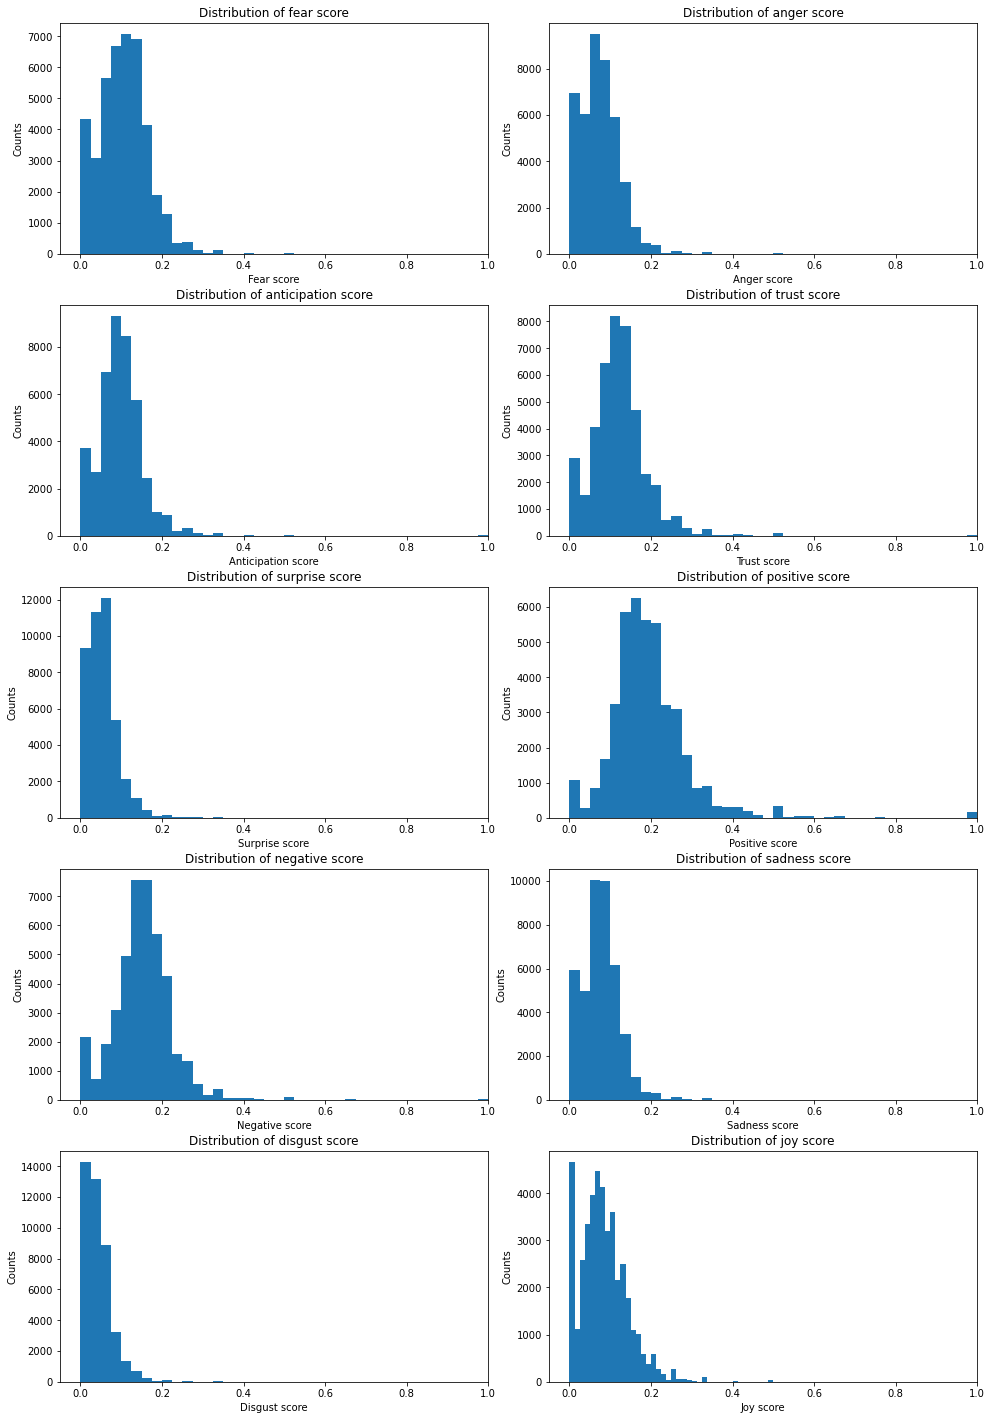

In [49]:
fig, axs = plt.subplots(5, 2, figsize=(14,20))
fig.tight_layout(pad=3)

sentiments = ["fear","anger","anticipation","trust","surprise","positive", "negative", "sadness", "disgust","joy"]
sentiment_idx=0
for i in range(5):
    for j in range(2):
        axs[i,j].hist(movies.multi_scores.apply(lambda score_dict: score_dict[sentiments[sentiment_idx]] if sentiments[sentiment_idx] in score_dict else 0),bins=40)
        axs[i,j].set_title('Distribution of {} score'.format(sentiments[sentiment_idx]))
        axs[i,j].set_xlabel('{} score'.format(sentiments[sentiment_idx].capitalize()))
        axs[i,j].set_ylabel('Counts')
        axs[i,j].set_xlim(-0.05,1)
        sentiment_idx+=1
plt.show()

## 3.2 Sentiments over time <a id='3.2'></a>

In this segment we want to analyze the sentiment scores over time. To do this we will use the bootstrap method to get a lower and an upper confidence interval bound for each score. We will begin our approach by applying this method for each year.

In [50]:
bootstrap_CIs_1year = {}
sentiments_SA = ['positive', 'negative', 'neutral', 'compound']
multi_sentiments=['fear','anger','trust','surprise','sadness','disgust','joy','anticipation']

for key in sentiments_SA+multi_sentiments:
    bootstrap_CIs_1year['Lower_{}'.format(key)]=[]
    bootstrap_CIs_1year['Upper_{}'.format(key)]=[]
    
for group_name, group in movies_with_year.groupby(["year"]):
    for key in sentiments_SA:
        bootstrap_CIs_1year['Lower_{}'.format(key)].append(bootstrap_CI(group['{}_score'.format(key)],1000)[0])
        bootstrap_CIs_1year['Upper_{}'.format(key)].append(bootstrap_CI(group['{}_score'.format(key)],1000)[1])
    for key_ in multi_sentiments:
        bootstrap_CIs_1year['Lower_{}'.format(key_)].append(bootstrap_CI(group['multi_{}'.format(key_)],1000)[0])
        bootstrap_CIs_1year['Upper_{}'.format(key_)].append(bootstrap_CI(group['multi_{}'.format(key_)],1000)[1])

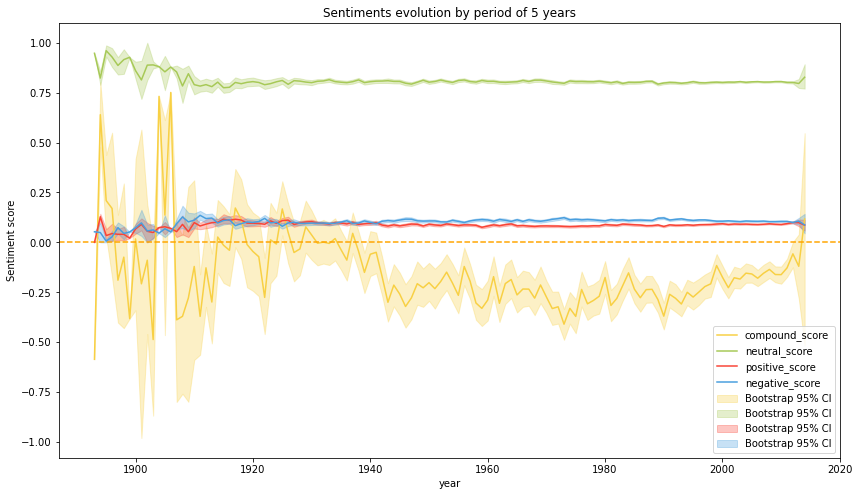

In [51]:
# PLot of SA over time (5years)

fig = plt.figure(figsize=(14,8))
#Mans
temp = movies_with_year.groupby(["year"])['compound_score'].mean()
fig = temp.plot(color='#f8d044')
temp = movies_with_year.groupby(["year"])['neutral_score'].mean()
fig = temp.plot(color='#a7c957')
fig = plt.axhline(y=0,color='orange',linestyle='--')
temp = movies_with_year.groupby(["year"])['positive_score'].mean()
fig = temp.plot(color='#f94436')
temp = movies_with_year.groupby(["year"])['negative_score'].mean()
fig = temp.plot(color='#489ede')


#Boostrap CIs for the mean scores
fig = plt.fill_between(np.sort(movies_with_year["year"].unique()),bootstrap_CIs_1year['Lower_compound'],bootstrap_CIs_1year['Upper_compound'], alpha = 0.3, color = '#f8d044',label='Bootstrap 95% CI')
fig = plt.fill_between(np.sort(movies_with_year["year"].unique()),bootstrap_CIs_1year['Lower_neutral'],bootstrap_CIs_1year['Upper_neutral'], alpha = 0.3, color = '#a7c957',label='Bootstrap 95% CI')
fig = plt.fill_between(np.sort(movies_with_year["year"].unique()),bootstrap_CIs_1year['Lower_positive'],bootstrap_CIs_1year['Upper_positive'], alpha = 0.3, color = '#f94436',label='Bootstrap 95% CI')
fig = plt.fill_between(np.sort(movies_with_year["year"].unique()),bootstrap_CIs_1year['Lower_negative'],bootstrap_CIs_1year['Upper_negative'], alpha = 0.3, color = '#489ede',label='Bootstrap 95% CI')

fig = plt.title("Sentiments evolution by period of 5 years")
fig = plt.ylabel('Sentiment score')
fig = plt.legend()
fig = plt.show()

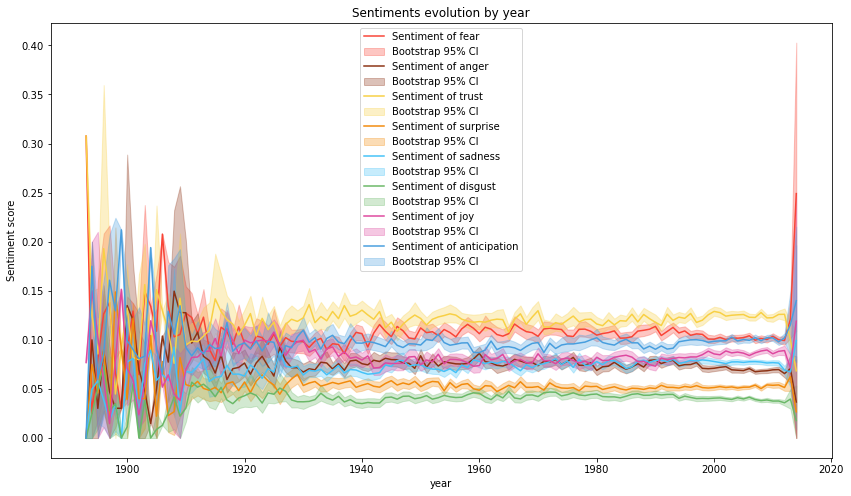

In [52]:
# Creating a colour palette for each sentiment
multi_sentiments_color_dict={'fear':'#f94436','anger':'#8c3214','trust':'#f8d044','surprise':'#f28b0c',
                             'sadness':'#44c2f8','disgust':'#6ab867','joy':'#de489f','anticipation':'#489ede'}

# PLot of multi SA over time (years)
multi_sentiments_color_dict={'fear':'#f94436','anger':'#8c3214','trust':'#f8d044','surprise':'#f28b0c',
                             'sadness':'#44c2f8','disgust':'#6ab867','joy':'#de489f','anticipation':'#489ede'}
fig = plt.figure(figsize=(14,8))

for key in multi_sentiments:
    temp = movies_with_year.groupby(["year"])['multi_{}'.format(key)].mean()
    fig = temp.plot(label='Sentiment of {}'.format(key), color=multi_sentiments_color_dict['{}'.format(key)])
    fig = plt.fill_between(np.sort(movies_with_year["year"].unique()),bootstrap_CIs_1year['Lower_{}'.format(key)],bootstrap_CIs_1year['Upper_{}'.format(key)], alpha = 0.3, color=multi_sentiments_color_dict['{}'.format(key)],label='Bootstrap 95% CI')
    

fig = plt.title("Sentiments evolution by year")
fig = plt.ylabel('Sentiment score')
fig = plt.legend(loc='upper center')
fig = plt.show()

In [53]:
bootstrap_CIs_5years = {}

for key in sentiments_SA+multi_sentiments:
    bootstrap_CIs_5years['Lower_{}'.format(key)]=[]
    bootstrap_CIs_5years['Upper_{}'.format(key)]=[]
    
for group_name, group in movies_with_year.groupby(["five_year_period"]):
    for key in sentiments_SA:
        bootstrap_CIs_5years['Lower_{}'.format(key)].append(bootstrap_CI(group['{}_score'.format(key)],1000)[0])
        bootstrap_CIs_5years['Upper_{}'.format(key)].append(bootstrap_CI(group['{}_score'.format(key)],1000)[1])
    for key_ in multi_sentiments:
        bootstrap_CIs_5years['Lower_{}'.format(key_)].append(bootstrap_CI(group['multi_{}'.format(key_)],1000)[0])
        bootstrap_CIs_5years['Upper_{}'.format(key_)].append(bootstrap_CI(group['multi_{}'.format(key_)],1000)[1])

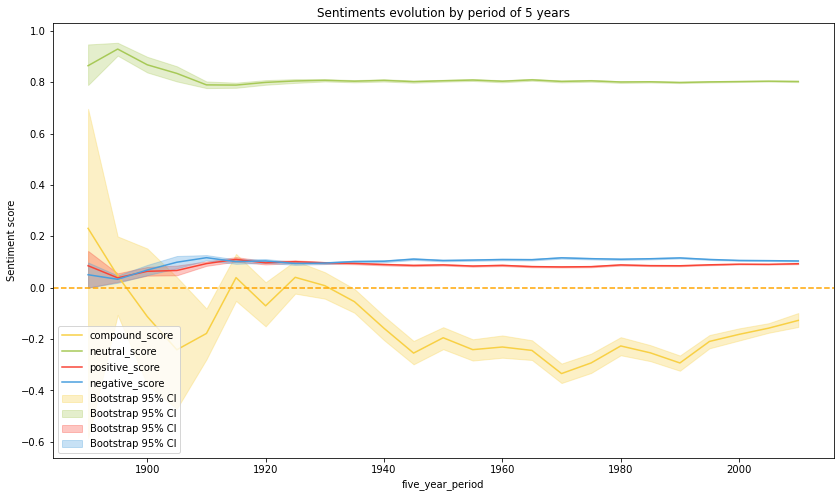

In [54]:
# PLot of SA over time (5years)

fig = plt.figure(figsize=(14,8))
#Mans
temp = movies_with_year.groupby(["five_year_period"])['compound_score'].mean()
fig = temp.plot(color='#f8d044')
temp = movies_with_year.groupby(["five_year_period"])['neutral_score'].mean()
fig = temp.plot(color='#a7c957')
fig = plt.axhline(y=0,color='orange',linestyle='--')
temp = movies_with_year.groupby(["five_year_period"])['positive_score'].mean()
fig = temp.plot(color='#f94436')
temp = movies_with_year.groupby(["five_year_period"])['negative_score'].mean()
fig = temp.plot(color='#489ede')


#Boostrap CIs for the mean scores
fig = plt.fill_between(np.sort(movies_with_year["five_year_period"].unique()),bootstrap_CIs_5years['Lower_compound'],bootstrap_CIs_5years['Upper_compound'], alpha = 0.3, color = '#f8d044',label='Bootstrap 95% CI')
fig = plt.fill_between(np.sort(movies_with_year["five_year_period"].unique()),bootstrap_CIs_5years['Lower_neutral'],bootstrap_CIs_5years['Upper_neutral'], alpha = 0.3, color = '#a7c957',label='Bootstrap 95% CI')
fig = plt.fill_between(np.sort(movies_with_year["five_year_period"].unique()),bootstrap_CIs_5years['Lower_positive'],bootstrap_CIs_5years['Upper_positive'], alpha = 0.3, color = '#f94436',label='Bootstrap 95% CI')
fig = plt.fill_between(np.sort(movies_with_year["five_year_period"].unique()),bootstrap_CIs_5years['Lower_negative'],bootstrap_CIs_5years['Upper_negative'], alpha = 0.3, color = '#489ede',label='Bootstrap 95% CI')

fig = plt.title("Sentiments evolution by period of 5 years")
fig = plt.ylabel('Sentiment score')
fig = plt.legend()
fig = plt.show()

Taking a closer look in the positive and negative score : 

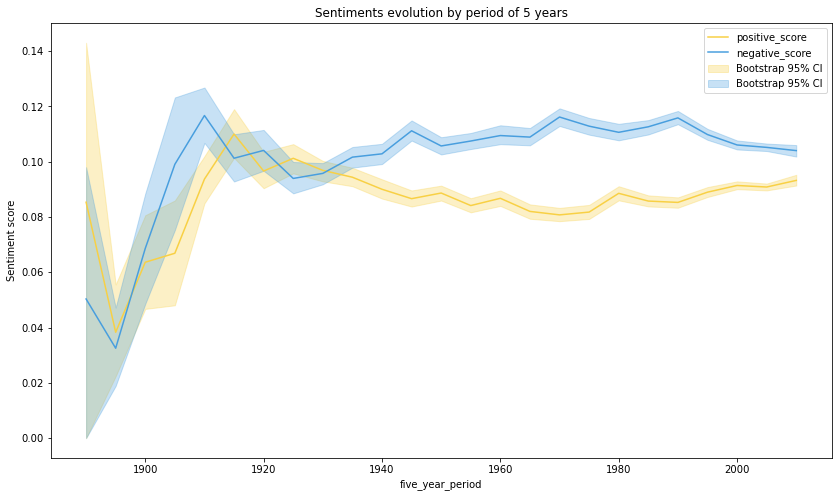

In [55]:
# PLot of SA over time (5years)

fig = plt.figure(figsize=(14,8))
temp = movies_with_year.groupby(["five_year_period"])['positive_score'].mean()
fig = temp.plot(color='#f8d044')
temp = movies_with_year.groupby(["five_year_period"])['negative_score'].mean()
fig = temp.plot(color='#489ede')
fig = plt.fill_between(np.sort(movies_with_year["five_year_period"].unique()),bootstrap_CIs_5years['Lower_positive'],bootstrap_CIs_5years['Upper_positive'], alpha = 0.3, color = '#f8d044',label='Bootstrap 95% CI')
fig = plt.fill_between(np.sort(movies_with_year["five_year_period"].unique()),bootstrap_CIs_5years['Lower_negative'],bootstrap_CIs_5years['Upper_negative'], alpha = 0.3, color = '#489ede',label='Bootstrap 95% CI')

fig = plt.title("Sentiments evolution by period of 5 years")
fig = plt.ylabel('Sentiment score')
fig = plt.legend()
fig = plt.show()

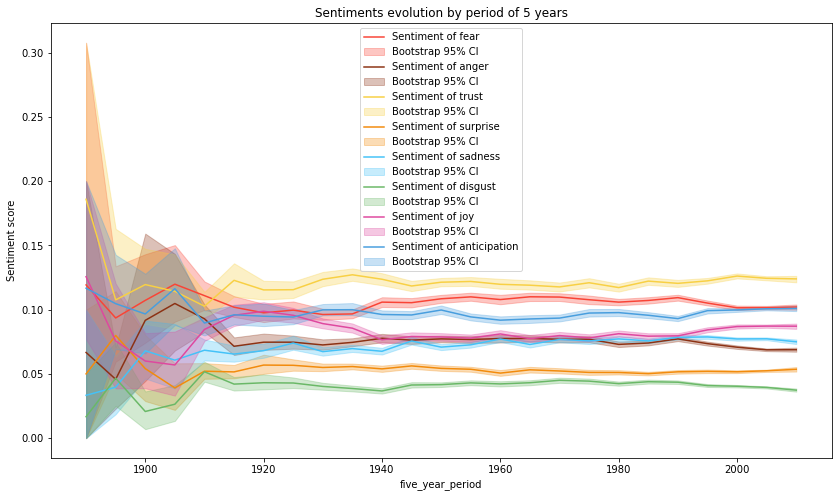

In [56]:
# PLot of multi SA over time (years)
fig = plt.figure(figsize=(14,8))

for key in multi_sentiments:
    temp = movies_with_year.groupby(["five_year_period"])['multi_{}'.format(key)].mean()
    fig = temp.plot(label='Sentiment of {}'.format(key), color=multi_sentiments_color_dict['{}'.format(key)])
    fig = plt.fill_between(np.sort(movies_with_year["five_year_period"].unique()),bootstrap_CIs_5years['Lower_{}'.format(key)],bootstrap_CIs_5years['Upper_{}'.format(key)], alpha = 0.3, color=multi_sentiments_color_dict['{}'.format(key)],label='Bootstrap 95% CI')
    

fig = plt.title("Sentiments evolution by period of 5 years")
fig = plt.ylabel('Sentiment score')
fig = plt.legend(loc='upper center')
fig = plt.show()

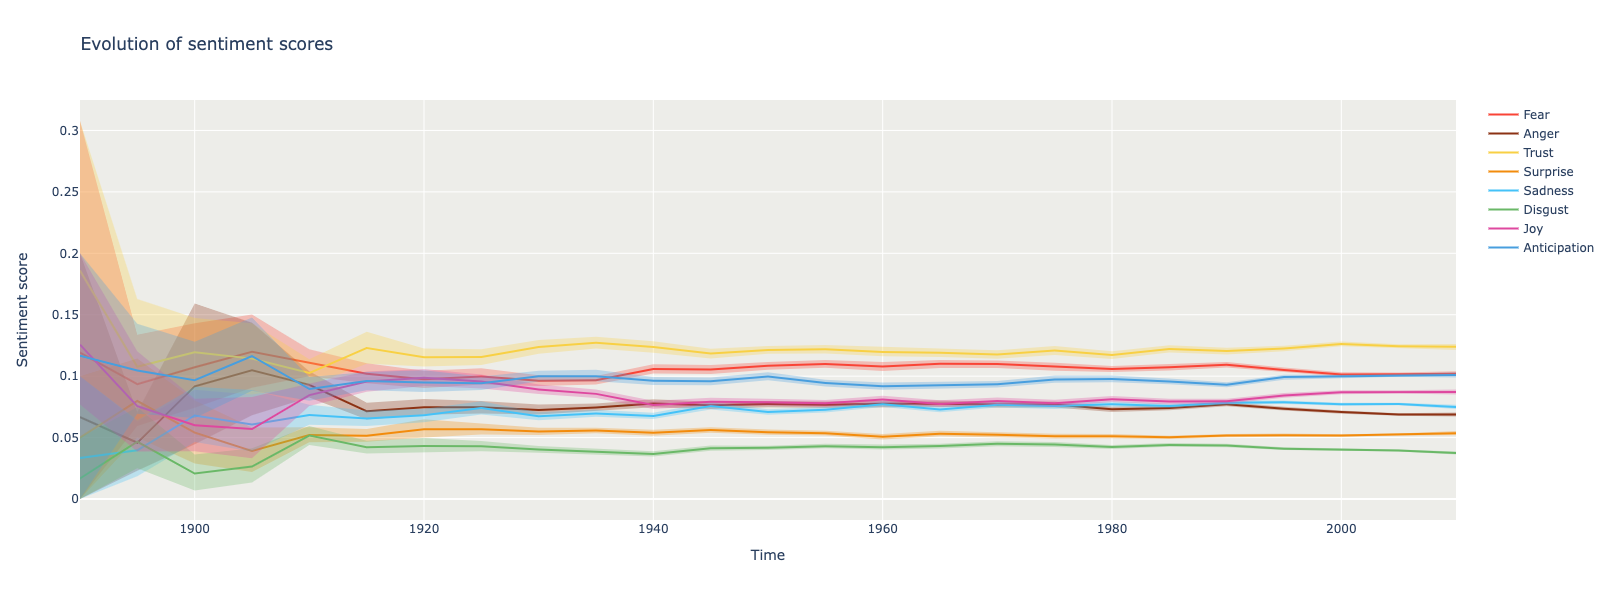

In [58]:
fig = make_subplots()
x = np.sort(movies_with_year["five_year_period"].unique()).tolist()

for key in multi_sentiments:
    # Mean of sentiment score over five year period -> sentiment according to "key"
    y = movies_with_year.groupby(["five_year_period"])['multi_{}'.format(key)].mean().values
    # Bootstrap 95% CI
    y_lower = bootstrap_CIs_5years['Lower_{}'.format(key)]
    y_upper = bootstrap_CIs_5years['Upper_{}'.format(key)]
    
    # Trace for mean score
    trace_mean_score = go.Scatter(  x=x,
                                    y=y,
                                    line=dict(color=multi_sentiments_color_dict[key]),
                                    mode='lines',
                                    name=key.capitalize()
                                 )
    # Tracce for CI
    trace_CI = go.Scatter(  x=x+x[::-1], 
                            y=y_upper+y_lower[::-1], 
                            fill='toself',
                            fillcolor=multi_sentiments_color_dict[key],
                            opacity=0.3,
                            line=dict(color='rgba(255,255,255,0)'),
                            hoverinfo="skip",
                            showlegend=False
                        )
    
    # Updating figure 
    fig.add_trace(trace_mean_score)
    fig.add_trace(trace_CI)

fig.update_layout(
    yaxis_title='Sentiment score',
    xaxis_title='Time',
    title='Evolution of sentiment scores',
    width=900,
    height=600,
    plot_bgcolor="#edede9",
    hovermode="x unified"
)
fig.show()
fig.write_html("output/sentiment_scores_time.html")
fig.write_image("output/plotly_static/sentiment_scores_time.png")

For more comments and an interactive version of this plot please visit our [website](https://clararenou.github.io/Refl-action/) 

![sentiment_scores_time!](output/plotly_static/sentiment_scores_time.png "sentiment_scores_time")

---

# 4. Combined <a id='4'></a>

## 4.1 Topics and sentiments <a id='4.1'></a>

### 4.1.1 Topics and sentiments association

To visualize the association of sentiments with each Bert topics (19 most frequent topics from all Bert topics), we use radar plot representations from the `plotly.graph_objects` library. First with neutral, positive and negative scores, then only with positive and negative scores and finally with all multi sentiment scores. 

In [59]:
#Compute the mean sentiment scores for each topic
temp = pd.DataFrame(columns = ['positive', 'negative', 'neutral', 'fear', 'anger', 'anticip', 'trust', 'surprise','positive_multi',
                               'negative_multi','sadness','disgust','joy','anticipation'], 
                   index = topics_BERT_20)
for topic in topics_BERT_20:
    #SA
    temp.at[topic,'positive'] = np.mean(movies[movies['BERT']==topic].positive_score)
    temp.at[topic,'negative'] = np.mean(movies[movies['BERT']==topic].negative_score)
    temp.at[topic,'neutral'] = np.mean(movies[movies['BERT']==topic].neutral_score)
    
    #Multi SA
    temp.at[topic,'fear'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['fear']))
    temp.at[topic,'anticip'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['anticip']))
    temp.at[topic,'trust'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['trust']))
    temp.at[topic,'surprise'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['surprise']))
    temp.at[topic,'positive_multi'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['positive']))
    temp.at[topic,'negative_multi'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['negative']))
    temp.at[topic,'sadness'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['sadness']))
    temp.at[topic,'disgust'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['disgust']))
    temp.at[topic,'joy'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['joy']))
    temp.at[topic,'anticipation'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['anticipation'] 
                                                                                             if 'anticipation' in score_dict else 0))
    temp.at[topic,'anger'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['anger']))
    

In [66]:
#Radar plot of BERT topics for neutral, negative and positive

theta_ = bert_topics.iloc[np.array(topics_BERT_20)+1]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
        r=temp.neutral,
        theta=theta_,
        fill='toself',
        name='Neutral sentiment',
        line_color = '#f94436'
))

fig.add_trace(go.Scatterpolar(
        r=temp.negative,
        theta=theta_,
        #mode = 'lines',
        fill='toself',
        name='Negative Sentiment',
        line_color = '#489ede'
))
fig.add_trace(go.Scatterpolar(
        r=temp.positive,
        theta=theta_,
        fill='toself',
        name='Positive sentiment',
        line_color = '#f8d044'
))



fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True,    
  plot_bgcolor="#edede9",
)

fig.show(renderer='iframe')
fig.write_html("output/radar_chart_trisentiment_BERT.html")
fig.write_image("output/plotly_static/radar_chart_trisentiment_BERT.png")

For more comments and an interactive version of this plot please visit our [website](https://clararenou.github.io/Refl-action/) 

![radar_chart_trisentiment_BERT!](output/plotly_static/radar_chart_trisentiment_BERT.png "radar_chart_trisentiment_BERT")

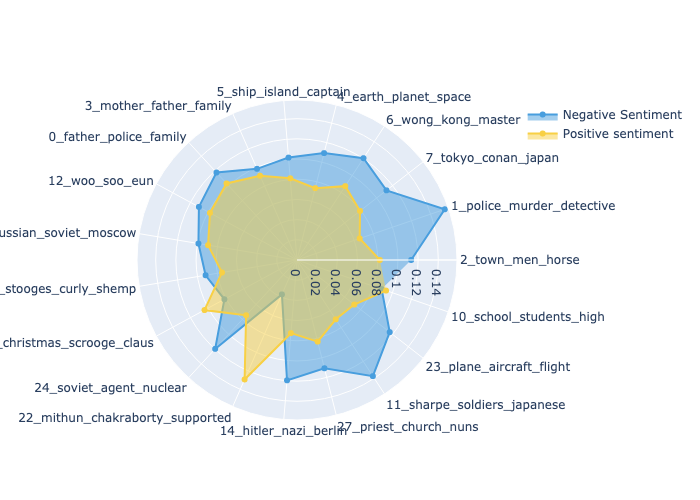

In [67]:
#Radar plot of BERT topics for only negative and positive

theta_ = bert_topics.iloc[np.array(topics_BERT_20)+1]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
        r=temp.negative,
        theta=theta_,
        #mode = 'lines',
        fill='toself',
        name='Negative Sentiment',
        line_color = '#489ede'
))
fig.add_trace(go.Scatterpolar(
        r=temp.positive,
        theta=theta_,
        fill='toself',
        name='Positive sentiment',
        line_color = '#f8d044'
))



fig.update_layout(
  plot_bgcolor="#edede9",
  polar=dict(
    radialaxis=dict(
      visible=True
    )),
  showlegend=True
)

fig.show(renderer='iframe')
fig.write_html("output/radar_chart_bisentiment_BERT.html")
fig.write_image("output/plotly_static/radar_chart_bisentiment_BERT.png")
fig.show("png")

In [ ]:
#Radar plot of BERT topics for multi SA

theta_ = bert_topics.iloc[np.array(topics_BERT_20)+1] 

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
        r=temp.trust,
        theta=theta_,
        fill='toself',
        name='Trust sentiment',
        line_color = '#f8d044'
))
fig.add_trace(go.Scatterpolar(
        r=temp.fear,
        theta=theta_,
        fill='toself',
        name='Fear sentiment',
        line_color = '#f94436'
))
fig.add_trace(go.Scatterpolar(
        r=temp.anticipation,
        theta=theta_,
        fill='toself',
        name='Anticipation sentiment',
        line_color = '#489ede'
))
#fig.add_trace(go.Scatterpolar(
 #       r=temp.positive_multi,
  #      theta=theta_,
   #     fill='toself',
    #    name='Positive sentiment',
     #   line_color = '#f8d044'
#))
#fig.add_trace(go.Scatterpolar(
 #       r=temp.negative_multi,
  #      theta=theta_,
   #     fill='toself',
    #    name='Negative sentiment',
      #  line_color = '#a39d99'
#))
fig.add_trace(go.Scatterpolar(
        r=temp.joy,
        theta=theta_,
        fill='toself',
        name='Joy sentiment',
        line_color = '#de489f'
))
fig.add_trace(go.Scatterpolar(
        r=temp.anger,
        theta=theta_,
        fill='toself',
        name='Anger sentiment',
        line_color = '#8c3214'
))
fig.add_trace(go.Scatterpolar(
        r=temp.sadness,
        theta=theta_,
        fill='toself',
        name='Sadness sentiment',
        line_color = '#44c2f8'
))
fig.add_trace(go.Scatterpolar(
        r=temp.surprise,
        theta=theta_,
        fill='toself',
        name='Surprise sentiment',
        line_color = '#f28b0c'
))
fig.add_trace(go.Scatterpolar(
        r=temp.disgust,
        theta=theta_,
        fill='toself',
        name='Disgust sentiment',
        line_color = '#6ab867'
))


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    )),
  showlegend=True
)

fig.show(renderer='iframe')
fig.write_html("output/radar_chart_multisentiment_BERT.html")
fig.write_image("output/plotly_static/radar_chart_multisentiment_BERT.png")

### 4.1.2 Topics and sentiments over time

In [ ]:
# Sentiments we have investigated
sentiments = ["positive_score", "negative_score", "multi_fear", "multi_anger", "multi_trust", "multi_surprise", "multi_sadness", "multi_disgust", "multi_joy", "multi_anticipation"]

# 
movies_reduced = BERT_movies_with_year[["five_year_period", "BERT"] + sentiments]

sentiments_df = pd.DataFrame()

# Reversing one hot encoding : We do this in order to be able to plot the interactive graph
## In this procedure we dont care about quality (what sentiment score each movie got) but quantity (average scores over years and topics)
## In the initial dataset "movies_reduced" we have 1 row per movie and 1 column for each sentiment. At the end of this loop we will create
## 10 rows for each movie (1 row per sentiment) where each row will have 1 column displaying the name of the sentiment, 1 for the score,
## and 1 for the relative score. Additionally, it will have 2 columns specifying the five_year_period and the BERT topic attributed to the movie.

for sentiment in sentiments:
    temp = movies_reduced[["five_year_period", "BERT"]].copy()
    temp["Sentiment"]= sentiment
    temp["Sentiment_score"]=movies_reduced[sentiment]
    sentiments_df = pd.concat([sentiments_df, temp])

# Getting the mean sentiment score for each five_year_period for each BERT topic
sentiments_df = sentiments_df.groupby(by=["Sentiment", "five_year_period", "BERT"]).mean()


# Putting the indexes into columns
sentiments_df = sentiments_df.reset_index(level=[0,1,2])



# Realtive sentiment score : Our sentiment scores are currently in the set [0,1]. We apply the following transformation to 
# each score f(x)= (100*x)^2 to emphasize on difference so it can be better displayed in the graph.
sentiments_df["Relative_sentiment_score"] = (sentiments_df["Sentiment_score"]*100)**2


fig = px.scatter(sentiments_df, x="five_year_period", y="BERT", animation_frame="Sentiment", 
           size="Relative_sentiment_score", color="BERT", hover_name="BERT", size_max=50, opacity = 0.7)


fig.update_layout( width = 900,
                   height = 700,
                   title_text = "Evolution of mean sentiment distribution over topics",
                   yaxis_title = "BERT Topic",
                   xaxis_title = "Time",
                   plot_bgcolor="#edede9"
                 )


fig["layout"].pop("updatemenus") # drop animation buttons -> no additional information
fig.show()
fig.write_html("output/bert_topics_time_sentiment.html")
fig.write_image("output/plotly_static/bert_topics_time_sentiment.png")

## 4.2 Topics and concerns

In [ ]:
#Compute the mean concern score for each topic
temp = pd.DataFrame(columns = ['ecological_concern', 'health_concern', 'conflict_concern', 'technological_concern', 'space_concern',
                               'gender_inequality_concern', 'homophobia_concern', 'racism_concern', 'mental_concern', 'relationships_concern'], 
                   index = topics_BERT_20)

for topic in topics_BERT_20:
    #Concerns
    temp.at[topic,'ecological_concern'] = np.mean(movies[movies['BERT']==topic].ecological_concern)
    temp.at[topic,'health_concern'] = np.mean(movies[movies['BERT']==topic].health_concern)
    temp.at[topic,'conflict_concern'] = np.mean(movies[movies['BERT']==topic].conflict_concern)
    temp.at[topic,'technological_concern'] = np.mean(movies[movies['BERT']==topic].technological_concern)
    temp.at[topic,'space_concern'] = np.mean(movies[movies['BERT']==topic].space_concern)
    temp.at[topic,'gender_inequality_concern'] = np.mean(movies[movies['BERT']==topic].gender_inequality_concern)
    temp.at[topic,'homophobia_concern'] = np.mean(movies[movies['BERT']==topic].homophobia_concern)
    temp.at[topic,'racism_concern'] = np.mean(movies[movies['BERT']==topic].racism_concern)
    temp.at[topic,'mental_concern'] = np.mean(movies[movies['BERT']==topic].mental_concern)
    temp.at[topic,'relationships_concern'] = np.mean(movies[movies['BERT']==topic].relationships_concern)                                             

In [ ]:
#Radar plot of BERT topics for concerns

theta_ = bert_topics.iloc[np.array(topics_BERT_20)+1] 

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
        r=temp.relationships_concern,
        theta=theta_,
        fill='toself',
        name='Relationships concern',
        line_color = '#f5abd5'
))
fig.add_trace(go.Scatterpolar(
        r=temp.conflict_concern,
        theta=theta_,
        fill='toself',
        name='Conflict_concern',
        line_color = '#f94436'
))
fig.add_trace(go.Scatterpolar(
        r=temp.space_concern,
        theta=theta_,
        fill='toself',
        name='Space concern',
        line_color = '#102a91'
))
fig.add_trace(go.Scatterpolar(
        r=temp.health_concern,
        theta=theta_,
        fill='toself',
        name='Health_concern',
        line_color = '#b4f78f'
))
fig.add_trace(go.Scatterpolar(
        r=temp.mental_concern,
        theta=theta_,
        fill='toself',
        name='Mental concern',
        line_color = '#44c2f8'
))
fig.add_trace(go.Scatterpolar(
        r=temp.ecological_concern,
        theta=theta_,
        fill='toself',
        name='Ecological concern',
        line_color = '#10800e'
))
fig.add_trace(go.Scatterpolar(
        r=temp.technological_concern,
        theta=theta_,
        fill='toself',
        name='Technological concern',
        line_color = '#de489f'
))
fig.add_trace(go.Scatterpolar(
        r=temp.gender_inequality_concern,
        theta=theta_,
        fill='toself',
        name='Gender inequality concern',
        line_color = '#8c3214'
))
fig.add_trace(go.Scatterpolar(
        r=temp.homophobia_concern,
        theta=theta_,
        fill='toself',
        name='Homophobia concern',
        line_color = '#f28b0c'
))
fig.add_trace(go.Scatterpolar(
        r=temp.racism_concern,
        theta=theta_,
        fill='toself',
        name='Racism concern',
        line_color = '#f8d044'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=True
)

fig.show(renderer='iframe')
fig.write_html("output/Concerns_vs_BERT.html")
fig.write_image("output/plotly_static/Concerns_vs_BERT.png")

## 4.3 Sentiments and concerns

In this section we will look for a correlation between the sentiments and the topics. In order to do that, we will perform multiple linear regressions where each regression will have the concern as an output and as inputs all the sentiments :

In [ ]:
from sklearn.linear_model import LinearRegression
X = movies.loc[:, sentiments]
coefficients = {}

for category in categories:
    y = movies[category]
    model = LinearRegression(fit_intercept=False, positive=True).fit(X,y)
    coefficients[category] = model.coef_

plot_coefficients = [coeff for coeff in coefficients.values()]

fig = go.Figure(data=go.Heatmap(
                   z=plot_coefficients,
                   x=sentiments,
                   y=categories,
                   hoverongaps = False,
                   colorscale="Reds"))

fig.update_layout( width = 800,
                   height = 600,
                   title_text = "Concerns correlated with sentiments",
                   yaxis_title = "Concerns",
                   xaxis_title = "Sentiments",
                 )
fig.show()
fig.write_html("output/heatmap_sentiments_concerns.html")
fig.write_image("output/plotly_static/heatmap_sentiments_concerns.png")

---

# 5. Statistical analysis

In this part, we are going through all the information we obtained from the plot summaries and we explore weither there exist statistically significant differences in topics, sentiments and concerns in general and across time. Also, we analyze the associations (if existing) across sentiments, across concerns, between sentiments and topics and, between sentiments and concerns.

**General method**

In order to **analyze differences in means across various groups**, we start by checking if there is at least one mean significatively different from another one. This can be done by one-way ANOVA under certain assumptions which are the independence of the diferent groups as well as the samples within groups; the homoscedasticity meaning that the diferent groups have the same variance; and the normality, the variable studied follows a normal distribution. ANOVA is quite robust against small assumptions violations but too big assumptions violations can render ANOVA not suited for our anlysis. In this case we can use an equivalent non-parametric test, here we use Kruskal-Wallis test. Then, when we have significant evidence for at least one difference in mean, we carry out a post hoc analysis using multiple comparisons tests to see which group has a significatively different mean from which other group. After ANOVA, the multiple comparisons are made with Tukey's  HSD test or thanks to pairwise Bootstap CIs of the differences in means, adjusted for multiple comparisons. After non parametric ANOVA, we use Dunn test.

In order to analyze **linear association**, we use Pearson correlation coefficient measuring linear correlation between two sets of data and also linear regression modelling the linear relationship between two sets of data.

## 5.1 Over time

We start with the analysis of evolutions over time. In part [1.2](#1.2), we create a new feature `year` that specify the release year for each movie provided with a plot summary, also, we obtain a new dataset `movies_with_year` for all the movies with plot summaries that have a release year which represents $39564$ movies.

Below, we explore a little bit `movies_with_year`. The number of datapoints per year is increasing with the year. In order to perform the analysis over time, we choose to divide our dataset into 3 time periods based on the 1/3 and 2/3 quantiles of the fearture `year`. This allows us to compare 3 time periods: `t1` (1983 to 1977), `t2` (1978 to 2002) and, `t3` (2003 to 2014).

In [ ]:
# General description of the variable year
movies_with_year['year'].describe()

In [ ]:
# Year distribution
movies_with_year['year'].hist()
plt.title("Distribution of the number of movies across time")
plt.xlabel("Year")
plt.ylabel("Count")

In [ ]:
# Defining thrsholds for our 3 time periods based on quantiles
year_thresholds = np.quantile(movies_with_year['year'],[1/3,2/3])
print('We can spit the data in equals group of years by taking years until {}, after {} and between these two.'.format(year_thresholds[0],year_thresholds[1]))

In [ ]:
movies_with_year["year"].unique()

### 5.1.1 Topics over time

Here we want to analyze the evolution of each topic representation over time, namely, we investigate the differences in topic proportions across t1, t2 and t3 groups for each topic.

We first create a data set containing the proportions of topics over time (`BERT_over_time`). Then we obtain 3 datasets, one per periof of time (`BERT_t1`, `BERT_t2` and `BERT_t3`), that will reprensent our 3 groups. For each topic, we can see big variation of standard deviation across the 3 groups, so here we use Krukal-Wallis test and Dunn test for multiple comparisons.

In [ ]:
# Create a new DataFrame with years as indices
BERT_over_years = pd.DataFrame(index = movies_with_year["year"].unique())
BERT_over_years.head()

In [ ]:
# Adding the count of movies per topic per year
topics=movies_with_year["BERT"].unique()

for topic in topics:
    BERT_over_years['{}'.format(topic)]= movies_with_year[movies_with_year.BERT==topic].groupby(["year"]).size()

In [ ]:
BERT_over_years.head()

In [ ]:
# Checks
print(len(movies_with_year[(movies_with_year.BERT==7) & (movies_with_year.year==2001.0)]))
print(len(movies_with_year[movies_with_year.BERT==7][movies_with_year.year==1983.0]))
print(len(movies_with_year[movies_with_year.BERT==0][movies_with_year.year==1997.0]))

In [ ]:
# Conversion to proportions
BERT_over_years = BERT_over_years.div(BERT_over_years.sum(axis=1), axis=0)
BERT_over_years.head()

In [ ]:
# Dataset with proportions of BERT topics from 1893 to 2002
t1_BERT = BERT_over_years[BERT_over_years.index <= year_thresholds[0]]
t1_BERT.describe()

In [ ]:
# Dataset with proportions of BERT topics from 1978 to 2002
t2_BERT = BERT_over_years[(BERT_over_years.index > year_thresholds[0]) & (BERT_over_years.index <= year_thresholds[1])]
t2_BERT.describe()

In [ ]:
# Dataset with proportions of BERT topics from 2003 to 2014
t3_BERT = BERT_over_years[BERT_over_years.index > year_thresholds[1]]
t3_BERT.describe()

In [ ]:
t3_BERT.head(3)

In [ ]:
#One way ANOVA non parametric

print('TOPICS OVER TIME')

for topic in topics:
    print('--------------------------------------------------------------------------------------------------------------')
    Kruskal = kruskal(t1_BERT['{}'.format(topic)],t2_BERT['{}'.format(topic)],t3_BERT['{}'.format(topic)])
    print("For topic {}, Kruskal results are: {}".format(topic,Kruskal))
    
    # If one significant difference, continue with multiple comparisons
    if (Kruskal.pvalue < 0.05):
        multiple_test = sp.posthoc_dunn([t1_BERT['{}'.format(topic)],t2_BERT['{}'.format(4)],t3_BERT['{}'.format(topic)]], p_adjust='bonferroni')
        if (multiple_test[1][3] < 0.05):
            if(t1_BERT['{}'.format(topic)].mean() < t3_BERT['{}'.format(topic)].mean()):
                print('There is a significative increase of topic {} proportion form t1 to t3 (pvalue={})'.format(topic,multiple_test[1][3]))
            else:
                print('There is a significative decrease of topic {} proportion form t1 to t3 (pvalue={})'.format(topic,multiple_test[1][3]))      
        if (multiple_test[1][2] < 0.05):
            if(t1_BERT['{}'.format(topic)].mean() < t2_BERT['{}'.format(topic)].mean()):
                print('There is a significative increase of topic {} proportion form t1 to t2 (pvalue={})'.format(topic,multiple_test[1][2]))
            else:
                print('There is a significative decrease of topic {} proportion form t1 to t2 (pvalue={})'.format(topic,multiple_test[1][2])) 
        if (multiple_test[2][3] < 0.05):
            if(t2_BERT['{}'.format(topic)].mean() < t3_BERT['{}'.format(topic)].mean()):
                print('There is a significative increase of topic {} proportion form t2 to t3 (pvalue={})'.format(topic,multiple_test[2][3]))
            else:
                print('There is a significative decrease of topic {} proportion form t2 to t3 (pvalue={})'.format(topic,multiple_test[2][3]))     

In [ ]:
# Not sure to keep it
for topic in topics:
    #fields slope, intercept, rvalue, pvalue and stderr
    #The p-value for a hypothesis test whose null hypothesis is that the slope is zero, 
    #using Wald Test with t-distribution of the test statistic. 
    slope, intercept, r, p, se = linregress(BERT_over_years.index, BERT_over_years['{}'.format(topic)])
    print("For topic {}, linear regression slope is {}, with a pvalue {}.".format(topic,slope, p))
    

---

### 5.1.2 Sentiments over time

Now, we want to investigate evoltuion of sentiments scores across time. For each sentiment score, we try to see if there is any difference of mean across our 3 periods of time. We firts create the 3 datsets for t1, t2 and t3. As sentiment scores seem to not violate ANOVA assumptions, we can carry out this test. Even if compound score has a bimodal distribution, ANOVA can be robust with large amount of data and we can get accurate estimations of statitics and p-values.

In [ ]:
t1_movies_with_year = movies_with_year[movies_with_year.year <= year_thresholds[0]]
print("Length of t1 dataset: {}".format(len(t1_movies_with_year)))

In [ ]:
t2_movies_with_year = movies_with_year[(movies_with_year.year > year_thresholds[0]) & (movies_with_year.year <= year_thresholds[1])]
print("Length of t2 dataset: {}".format(len(t2_movies_with_year)))

In [ ]:
t3_movies_with_year = movies_with_year[movies_with_year.year > year_thresholds[1]]
print("Length of t3 dataset: {}".format(len(t3_movies_with_year)))

#### 5.1.2.1 Compound

The compound score is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive).

Here, we try to model the evolution of compound score by a linear function of time to see the global trend if any significant one.

In [ ]:
# Ordinary Least Squares Linear Regression 

mod = smf.ols(formula='compound_score ~ year', data=movies_with_year)
res = mod.fit()
print(res.summary())

In [ ]:
movies_with_year['compound_score'].describe()

The slope of the linear relationship, $\widehat{Compound score} = 0.7325 - 0.005 year$, is significatively different from 0. Across time we have an overall decrease of the compound score, which means that the plot summaries are less positive and more negative with evolution of time in general. But, we can see some problemes with this approach as $R^2$ is 0.

We can try another method comparing compoud score across periods of time.

In [ ]:
# One-way ANOVA
Anova = f_oneway(t1_movies_with_year['{}'.format(sentiment)],t2_movies_with_year['{}'.format(sentiment)],t3_movies_with_year['{}'.format(sentiment)])
print("For {}, ANOVA results are: {}".format(sentiment,Anova))

# If one significant difference, continue with multiple comparisons
if (Anova.pvalue < 0.05):
    multiple_test = sp.posthoc_tukey([t1_movies_with_year['{}'.format(sentiment)],t2_movies_with_year['{}'.format(sentiment)],t3_movies_with_year['{}'.format(sentiment)]])
    if (multiple_test[1][3] < 0.05):
        if(t1_movies_with_year['{}'.format(sentiment)].mean() < t3_movies_with_year['{}'.format(sentiment)].mean()):
            print('There is a significative increase of {} proportion form t1 to t3 (pvalue={})'.format(sentiment,multiple_test[1][3]))
        else:
            print('There is a significative decrease of {} proportion form t1 to t3 (pvalue={})'.format(sentiment,multiple_test[1][3]))      
    if (multiple_test[1][2] < 0.05):
        if(t1_movies_with_year['{}'.format(sentiment)].mean() < t2_movies_with_year['{}'.format(sentiment)].mean()):
            print('There is a significative increase of {} proportion form t1 to t2 (pvalue={})'.format(sentiment,multiple_test[1][2]))
        else:
            print('There is a significative decrease of {} proportion form t1 to t2 (pvalue={})'.format(sentiment,multiple_test[1][2])) 
    if (multiple_test[2][3] < 0.05):
        if(t2_movies_with_year['{}'.format(sentiment)].mean() < t3_movies_with_year['{}'.format(sentiment)].mean()):
            print('There is a significative increase of {} proportion form t2 to t3 (pvalue={})'.format(sentiment,multiple_test[2][3]))
        else:
            print('There is a significative decrease of {} proportion form t2 to t3 (pvalue={})'.format(sentiment,multiple_test[2][3]))     

In [ ]:
# Display groups means
print('Mean of compound score in t1: {}; t2: {} and t3: {}'.format(t1_movies_with_year['compound_score'].mean(),t2_movies_with_year['compound_score'].mean(),
                                                                   t3_movies_with_year['compound_score'].mean()))
                                                                   

In [ ]:
# One-sample t-test, compare compound score to 0 in t1
stats.ttest_1samp(t1_movies_with_year['compound_score'], 0)

In [ ]:
# One-sample t-test, compare compound score to 0 in t2
stats.ttest_1samp(t2_movies_with_year['compound_score'], 0)

In [ ]:
# One-sample t-test, compare compound score to 0 in t3
stats.ttest_1samp(t3_movies_with_year['compound_score'], 0)

We can see that the compound score is significatively below 0, which means that plot summaries are more negative.

#### 5.1.2.2 All sentiments

In [ ]:
# One way ANOVA 

print('SENTIMENTS OVER TIME')
sentiments=['positive_score', 'negative_score', 'neutral_score',
        'multi_fear', 'multi_anger', 'multi_trust',
       'multi_surprise', 'multi_sadness', 'multi_disgust', 'multi_joy',
       'multi_anticipation']

for sentiment in sentiments:
    print('--------------------------------------------------------------------------------------------------------------')
    Anova = f_oneway(t1_movies_with_year['{}'.format(sentiment)],t2_movies_with_year['{}'.format(sentiment)],t3_movies_with_year['{}'.format(sentiment)])
    print("For {}, ANOVA results are: {}".format(sentiment,Anova))
    
    # If one significant difference, continue with multiple comparisons
    if (Anova.pvalue < 0.05):
        multiple_test = sp.posthoc_tukey([t1_movies_with_year['{}'.format(sentiment)],t2_movies_with_year['{}'.format(sentiment)],t3_movies_with_year['{}'.format(sentiment)]])
        if (multiple_test[1][3] < 0.05):
            if(t1_movies_with_year['{}'.format(sentiment)].mean() < t3_movies_with_year['{}'.format(sentiment)].mean()):
                print('There is a significative increase of {} proportion form t1 to t3 (pvalue={})'.format(sentiment,multiple_test[1][3]))
            else:
                print('There is a significative decrease of {} proportion form t1 to t3 (pvalue={})'.format(sentiment,multiple_test[1][3]))      
        if (multiple_test[1][2] < 0.05):
            if(t1_movies_with_year['{}'.format(sentiment)].mean() < t2_movies_with_year['{}'.format(sentiment)].mean()):
                print('There is a significative increase of {} proportion form t1 to t2 (pvalue={})'.format(sentiment,multiple_test[1][2]))
            else:
                print('There is a significative decrease of {} proportion form t1 to t2 (pvalue={})'.format(sentiment,multiple_test[1][2])) 
        if (multiple_test[2][3] < 0.05):
            if(t2_movies_with_year['{}'.format(sentiment)].mean() < t3_movies_with_year['{}'.format(sentiment)].mean()):
                print('There is a significative increase of {} proportion form t2 to t3 (pvalue={})'.format(sentiment,multiple_test[2][3]))
            else:
                print('There is a significative decrease of {} proportion form t2 to t3 (pvalue={})'.format(sentiment,multiple_test[2][3]))     

### 5.1.3 Concern categories over time

Here, we investigate concerns scores evolution over our 3 periods of time. 

In [ ]:
# One way ANOVA 

print('CONCERNS OVER TIME')
concerns=['ecological_concern',
       'health_concern', 'conflict_concern', 'technological_concern',
       'space_concern', 'gender_inequality_concern', 'homophobia_concern',
       'racism_concern', 'mental_concern', 'relationships_concern']

for concern in concerns:
    print('--------------------------------------------------------------------------------------------------------------')
    Anova = f_oneway(t1_movies_with_year['{}'.format(concern)],t2_movies_with_year['{}'.format(concern)],t3_movies_with_year['{}'.format(concern)])
    print("For {}, ANOVA results are: {}".format(concern,Anova))
    
     # If one significant difference, continue with multiple comparisons
    if (Anova.pvalue < 0.05):
        multiple_test = sp.posthoc_tukey([t1_movies_with_year['{}'.format(concern)],t2_movies_with_year['{}'.format(concern)],t3_movies_with_year['{}'.format(concern)]])
        if (multiple_test[1][3] < 0.05):
            if(t1_movies_with_year['{}'.format(concern)].mean() < t3_movies_with_year['{}'.format(concern)].mean()):
                print('There is a significative increase of {} proportion form t1 to t3 (pvalue={})'.format(concern,multiple_test[1][3]))
            else:
                print('There is a significative decrease of {} proportion form t1 to t3 (pvalue={})'.format(concern,multiple_test[1][3]))      
        if (multiple_test[1][2] < 0.05):
            if(t1_movies_with_year['{}'.format(concern)].mean() < t2_movies_with_year['{}'.format(concern)].mean()):
                print('There is a significative increase of {} proportion form t1 to t2 (pvalue={})'.format(concern,multiple_test[1][2]))
            else:
                print('There is a significative decrease of {} proportion form t1 to t2 (pvalue={})'.format(concern,multiple_test[1][2])) 
        if (multiple_test[2][3] < 0.05):
            if(t2_movies_with_year['{}'.format(concern)].mean() < t3_movies_with_year['{}'.format(concern)].mean()):
                print('There is a significative increase of {} proportion form t2 to t3 (pvalue={})'.format(concern,multiple_test[2][3]))
            else:
                print('There is a significative decrease of {} proportion form t2 to t3 (pvalue={})'.format(concern,multiple_test[2][3]))     

## 5.2 Overall

### 5.2.1 Sentiments

#### 5.2.1.1 During the whole period

We consider the sentiments: positive, negative, neutral, fear, anger, trust, surprise, sadness, disgust, joy and anticipation. Now, we check for the linear correlation between the different sentiments using Pearson correlation coefficient. And then we test whether there is difference in mean scores across sentiments using ANOVA and Tukey's HSD tests.

In [ ]:
# Linear correlation across all sentiments
corr_sentiments=movies[sentiments].corr(method='pearson')
corr_sentiments.style.background_gradient(cmap='coolwarm').set_precision(2)

We can read on this table:
- Positive sentiment is 
    - positively linearly correlated with joy sentiment 
    - negatively linearly correlated with neutral sentiment and, to a less extent, with fear and anger.
- Negative sentiment is
    - positively linearly correlated with fear and anger sentiment and, to a less extent, with sadness and disgust
    - negatively linearly correlated with neutral sentiment and, to a less extent, with joy.
- Fear sentiment is
    - positively linearly correlated with fear and anger sentiment
    - negatively linearly correlated with joy sentiment and, to a less extent, with anticipation and trust.
- Trust sentiment is
    - weakly negatively linearly correlated with sadness.
- Sadness sentiment is
    - weakly negatively linearly correlated with joy.
- Disgust sentiment is
    - weakly negatively linearly correlated with joy.
- Joy sentiment is
    - weakly positively linearly correlated with anticipation.

In [ ]:
# One way ANOVA 

print('OVERALL SENTIMENTS')

print('--------------------------------------------------------------------------------------------------------------')
Anova = f_oneway(movies['positive_score'], movies['negative_score'], movies['neutral_score'],
        movies['multi_fear'], movies['multi_anger'], movies['multi_trust'],
       movies['multi_surprise'], movies['multi_sadness'], movies['multi_disgust'], movies['multi_joy'],
       movies['multi_anticipation'])
print("For all sentiments, ANOVA results are: {}".format(Anova))


In [ ]:
# Post-hoc analysis because significant ANOVA results
multiple_test = sp.posthoc_tukey([movies['positive_score'], movies['negative_score'], movies['neutral_score'],
        movies['multi_fear'], movies['multi_anger'], movies['multi_trust'],
       movies['multi_surprise'], movies['multi_sadness'], movies['multi_disgust'], movies['multi_joy'],
       movies['multi_anticipation']])
print("Table of adjusted pvalues from multiple comparisons:")
multiple_test     

In [ ]:
# Visualization of adjusted p-values for multiple comparisons
sp.sign_plot(multiple_test)

All sentiment scores are significatively different, so we can order them by mean.

In [ ]:
# Means for sentiments scores
movies[sentiments].mean().sort_values(ascending=False)

#### 5.2.1.2 During t1

We perform the same analysis as described above but with a focus on what happens in t1 period only. So,we check for the linear correlation between the different sentiments in t1. And then we test whether there is difference in mean scores across sentiments during t1 only.

In [ ]:
# Linear correlation across all sentiments during t1
corr_sentiments=t1_movies_with_year[sentiments].corr(method='pearson')
corr_sentiments.style.background_gradient(cmap='coolwarm').set_precision(2)

The correlations ar the same as the ones described above.

In [ ]:
# One way ANOVA 

print('SENTIMENTS DURING T1')

print('--------------------------------------------------------------------------------------------------------------')
Anova = f_oneway(t1_movies_with_year['positive_score'], t1_movies_with_year['negative_score'], t1_movies_with_year['neutral_score'],
        t1_movies_with_year['multi_fear'], t1_movies_with_year['multi_anger'], t1_movies_with_year['multi_trust'],
       t1_movies_with_year['multi_surprise'], t1_movies_with_year['multi_sadness'], t1_movies_with_year['multi_disgust'], t1_movies_with_year['multi_joy'],
       t1_movies_with_year['multi_anticipation'])
print("For all sentiments, ANOVA results are: {}".format(Anova))


In [ ]:
# Post-hoc analysis because ANOVA gives significative results
multiple_test = sp.posthoc_tukey([t1_movies_with_year['positive_score'], t1_movies_with_year['negative_score'], t1_movies_with_year['neutral_score'],
        t1_movies_with_year['multi_fear'], t1_movies_with_year['multi_anger'], t1_movies_with_year['multi_trust'],
       t1_movies_with_year['multi_surprise'], t1_movies_with_year['multi_sadness'], t1_movies_with_year['multi_disgust'], t1_movies_with_year['multi_joy'],
       t1_movies_with_year['multi_anticipation']])
print("Table of adjusted pvalues from multiple comparisons:")
multiple_test     

In [ ]:
# Visualization of ajdjusted p-values
sp.sign_plot(multiple_test)

During t1 period, all sentiment scores are significatively different, except for fear and negative sentiment, so we can order them by mean.

In [ ]:
#Means of sentiments scores during t1
t1_movies_with_year[sentiments].mean().sort_values(ascending=False)

#### 5.2.1.3 During t2

We repeat the analysis for t2 period.

In [ ]:
# Correlations
corr_sentiments=t2_movies_with_year[sentiments].corr(method='pearson')
corr_sentiments.style.background_gradient(cmap='coolwarm').set_precision(2)

There is no big difference in sentiment correlations.

In [ ]:
# One way ANOVA

print('SENTIMENTS DURING T2')

print('--------------------------------------------------------------------------------------------------------------')
Anova = f_oneway(t2_movies_with_year['positive_score'], t2_movies_with_year['negative_score'], t2_movies_with_year['neutral_score'],
        t2_movies_with_year['multi_fear'], t2_movies_with_year['multi_anger'], t2_movies_with_year['multi_trust'],
       t2_movies_with_year['multi_surprise'], t2_movies_with_year['multi_sadness'], t2_movies_with_year['multi_disgust'], t2_movies_with_year['multi_joy'],
       t2_movies_with_year['multi_anticipation'])
print("For all sentiments, ANOVA results are: {}".format(Anova))


In [ ]:
# Post-hoc analysis
multiple_test = sp.posthoc_tukey([t2_movies_with_year['positive_score'], t2_movies_with_year['negative_score'], t2_movies_with_year['neutral_score'],
        t2_movies_with_year['multi_fear'], t2_movies_with_year['multi_anger'], t2_movies_with_year['multi_trust'],
       t2_movies_with_year['multi_surprise'], t2_movies_with_year['multi_sadness'], t2_movies_with_year['multi_disgust'], t2_movies_with_year['multi_joy'],
       t2_movies_with_year['multi_anticipation']])
print("Table of adjusted pvalues from multiple comparisons:")
multiple_test     

In [ ]:
# Visualization of adjusted pvalues
sp.sign_plot(multiple_test)

During t2 period, all sentiment scores are significatively different, so we can order them by mean.

In [ ]:
# Means
t2_movies_with_year[sentiments].mean().sort_values(ascending=False)

#### 5.2.1.4 During t3

We repeat the analysis for t3 period.

In [ ]:
# Correlations
corr_sentiments=t3_movies_with_year[sentiments].corr(method='pearson')
corr_sentiments.style.background_gradient(cmap='coolwarm').set_precision(2)

In [ ]:
# One way ANOVA

print('SENTIMENTS DURING T3')

print('--------------------------------------------------------------------------------------------------------------')
Anova = f_oneway(t3_movies_with_year['positive_score'], t3_movies_with_year['negative_score'], t3_movies_with_year['neutral_score'],
        t3_movies_with_year['multi_fear'], t3_movies_with_year['multi_anger'], t3_movies_with_year['multi_trust'],
       t3_movies_with_year['multi_surprise'], t3_movies_with_year['multi_sadness'], t3_movies_with_year['multi_disgust'], t3_movies_with_year['multi_joy'],
       t3_movies_with_year['multi_anticipation'])
print("For all sentiments, ANOVA results are: {}".format(Anova))


In [ ]:
# Post-hoc analysis 
multiple_test = sp.posthoc_tukey([t3_movies_with_year['positive_score'], t3_movies_with_year['negative_score'], t3_movies_with_year['neutral_score'],
        t3_movies_with_year['multi_fear'], t3_movies_with_year['multi_anger'], t3_movies_with_year['multi_trust'],
       t3_movies_with_year['multi_surprise'], t3_movies_with_year['multi_sadness'], t3_movies_with_year['multi_disgust'], t3_movies_with_year['multi_joy'],
       t3_movies_with_year['multi_anticipation']])
print("Table of adjusted pvalues from multiple comparisons:")
multiple_test     

In [ ]:
# Visualization of adjusted p-values
sp.sign_plot(multiple_test)

During t3 period, all sentiment scores are significatively different, except for fear and anticipation, so we can order them by mean.

In [ ]:
# Means
t3_movies_with_year[sentiments].mean().sort_values(ascending=False)

### 5.2.2 Concern categories

Here, we consider the concerns: ecologicy, health, conflict, technology, space, gender inequality, homophobia, racism, mental and relationships. We check for the linear correlation between the different concerns using Pearson correlation coefficient. And then we test whether there is difference in mean scores across concerns using ANOVA and Tukey's HSD tests. We will perform this analysis for the whole period of time, for t1 period ,for t2 period and for t3 period.

#### 5.2.2.1 During the whole period

In [ ]:
# Correlations
corr_concerns=movies[concerns].corr(method='pearson')
corr_concerns.style.background_gradient(cmap='coolwarm').set_precision(2)

We can read on this table:
- Ecological concern is 
    - positively linearly correlated with technological concern. 
- Health concern is
    - weakly positively linearly correlated with mental concern.
- Gender inequality concern is
    - positively linearly correlated with homophobia and racism concerns.
- Homophobia concern is
    - positively linearly correlated with racism concern.

In [ ]:
# One way ANOVA

print('OVERALL CONCERNS')

print('--------------------------------------------------------------------------------------------------------------')
Anova = f_oneway(movies['ecological_concern'], movies['health_concern'], movies['conflict_concern'],
        movies['technological_concern'], movies['space_concern'], movies['gender_inequality_concern'],
       movies['homophobia_concern'], movies['racism_concern'], movies['mental_concern'], movies['relationships_concern'])
print("For all concerns, ANOVA results are: {}".format(Anova))


In [ ]:
# Post-hoc analysis
multiple_test = sp.posthoc_tukey([movies['ecological_concern'], movies['health_concern'], movies['conflict_concern'],
        movies['technological_concern'], movies['space_concern'], movies['gender_inequality_concern'],
       movies['homophobia_concern'], movies['racism_concern'], movies['mental_concern'], movies['relationships_concern']])
print("Table of adjusted pvalues from multiple comparisons:")
multiple_test     

In [ ]:
# Visualization of p-values
sp.sign_plot(multiple_test)

We can observe bidirectional comparisons results:

- Ecological concern scores are not significatively different from technological, gender and homophobia concerns scores. 
- Health concern scores are not significatively different from space concern scores. 
- Technological concern scores are not significatively different from gender inequality, homophobia and racism concern scores. - Gender inequality concern scores are not significatively different from racism and homophobia ones.


All the other comparisons show significant differences in scores.

In [ ]:
# Means
movies[concerns].mean().sort_values(ascending=False)

#### 5.2.2.2 During t1

In [ ]:
# Correlations
corr_concerns=t1_movies_with_year[concerns].corr(method='pearson')
corr_concerns.style.background_gradient(cmap='coolwarm').set_precision(2)

In [ ]:
# One way ANOVA 

print('OVERALL CONCERNS DURING T1')

print('--------------------------------------------------------------------------------------------------------------')
Anova = f_oneway(t1_movies_with_year['ecological_concern'], t1_movies_with_year['health_concern'], t1_movies_with_year['conflict_concern'],
        t1_movies_with_year['technological_concern'], t1_movies_with_year['space_concern'], t1_movies_with_year['gender_inequality_concern'],
       t1_movies_with_year['homophobia_concern'], t1_movies_with_year['racism_concern'], t1_movies_with_year['mental_concern'], t1_movies_with_year['relationships_concern'])
print("For all concerns, ANOVA results are: {}".format(Anova))


In [ ]:
# Post-hoc analysis
multiple_test = sp.posthoc_tukey([t1_movies_with_year['ecological_concern'], t1_movies_with_year['health_concern'], t1_movies_with_year['conflict_concern'],
        t1_movies_with_year['technological_concern'], t1_movies_with_year['space_concern'], t1_movies_with_year['gender_inequality_concern'],
       t1_movies_with_year['homophobia_concern'], t1_movies_with_year['racism_concern'], t1_movies_with_year['mental_concern'], t1_movies_with_year['relationships_concern']])
print("Table of adjusted pvalues from multiple comparisons:")
multiple_test     

In [ ]:
# Visualization of adjusted p-values
sp.sign_plot(multiple_test)

During t1 period, what differ from the overall period of time is that we do not have significative differences between technology and racism concerns scores and between racism and homophobia.

In [ ]:
# Means during t1
t1_movies_with_year[concerns].mean().sort_values(ascending=False)

#### 5.2.2.3 During t2

In [ ]:
# Correlations
corr_concerns=t2_movies_with_year[concerns].corr(method='pearson')
corr_concerns.style.background_gradient(cmap='coolwarm').set_precision(2)

In [ ]:
# One way ANOVA 

print('OVERALL CONCERNS DURING T2')

print('--------------------------------------------------------------------------------------------------------------')
Anova = f_oneway(t2_movies_with_year['ecological_concern'], t2_movies_with_year['health_concern'], t2_movies_with_year['conflict_concern'],
        t2_movies_with_year['technological_concern'], t2_movies_with_year['space_concern'], t2_movies_with_year['gender_inequality_concern'],
       t2_movies_with_year['homophobia_concern'], t2_movies_with_year['racism_concern'], t2_movies_with_year['mental_concern'], t2_movies_with_year['relationships_concern'])
print("For all concerns, ANOVA results are: {}".format(Anova))


In [ ]:
# Post-hoc analysis
multiple_test = sp.posthoc_tukey([t2_movies_with_year['ecological_concern'], t2_movies_with_year['health_concern'], t2_movies_with_year['conflict_concern'],
        t2_movies_with_year['technological_concern'], t2_movies_with_year['space_concern'], t2_movies_with_year['gender_inequality_concern'],
       t2_movies_with_year['homophobia_concern'], t2_movies_with_year['racism_concern'], t2_movies_with_year['mental_concern'], t2_movies_with_year['relationships_concern']])
print("Table of adjusted pvalues from multiple comparisons:")
multiple_test     

In [ ]:
# Visualization of adjusted p-values
sp.sign_plot(multiple_test)

During t2 period, what differ from the overall period of time is that we do not have significative differences between technology and racism concerns scores, between racism and homophobia and between health and mental concerns scores. Also, while in the overall period there was no significant difference between space and health there is one during t2.

In [ ]:
# Means t2
t2_movies_with_year[concerns].mean().sort_values(ascending=False)

#### 5.2.2.4 During t3

In [ ]:
# Correlations
corr_concerns=t3_movies_with_year[concerns].corr(method='pearson')
corr_concerns.style.background_gradient(cmap='coolwarm').set_precision(2)

In t3 there is an observable inscrease in correlation between racism concern and gender inequality concern scores.

In [ ]:
# One way ANOVA 

print('OVERALL CONCERNS DURING T3')

print('--------------------------------------------------------------------------------------------------------------')
Anova = f_oneway(t3_movies_with_year['ecological_concern'], t3_movies_with_year['health_concern'], t3_movies_with_year['conflict_concern'],
        t3_movies_with_year['technological_concern'], t3_movies_with_year['space_concern'], t3_movies_with_year['gender_inequality_concern'],
       t3_movies_with_year['homophobia_concern'], t3_movies_with_year['racism_concern'], t3_movies_with_year['mental_concern'], t3_movies_with_year['relationships_concern'])
print("For all concerns, ANOVA results are: {}".format(Anova))


In [ ]:
# Post-hoc analysis
multiple_test = sp.posthoc_tukey([t3_movies_with_year['ecological_concern'], t3_movies_with_year['health_concern'], t3_movies_with_year['conflict_concern'],
        t3_movies_with_year['technological_concern'], t3_movies_with_year['space_concern'], t3_movies_with_year['gender_inequality_concern'],
       t3_movies_with_year['homophobia_concern'], t3_movies_with_year['racism_concern'], t3_movies_with_year['mental_concern'], t3_movies_with_year['relationships_concern']])
print("Table of adjusted pvalues from multiple comparisons:")
multiple_test     

In [ ]:
# Visualization of p-values
sp.sign_plot(multiple_test)

During t3 period, what differ from the overall period of time is that we do not have significative differences between technology and racism concerns scores and between racism and homophobia as in t1.

In [ ]:
# Means t3
t3_movies_with_year[concerns].mean().sort_values(ascending=False)

## 5.3 Sentiments and topics

In this part, for each sentiment, we test wheter the scores varry significantly across the different topics.

In [ ]:
print("SENTIMENTS AND TOPICS")
for sentiment in sentiments:
    print('--------------------------------------------------------------------------------------------------------------')
    grps = [d['{}'.format(sentiment)] for _, d in movies.groupby('BERT')]
    Anova = f_oneway(*grps)
    print("For {}, ANOVA results are: {}".format(sentiment,Anova))

All sentiments have a difference in scores across at least 2 different topics.

In [ ]:
# Post-hoc analysis, print for each sentiment all the topics pairs where we have a significant difference in mean scores.
for sentiment in sentiments:
    print('-----------------------------------Multiple comparisons------------------------------------------------------------')
    grps = [d['{}'.format(sentiment)] for _, d in movies.groupby('BERT')]
    names =[n for n, d in movies.groupby('BERT')]
    multiple_test = sp.posthoc_tukey([*grps])
    print('Multiple comparisons for {}, the topics comparisons with significative differences in {} are:'.format(sentiment,sentiment))
    sig = list(zip(list(np.where(multiple_test < 0.05)[0]),list(np.where(multiple_test < 0.05)[1])))
    sig_sorted = sorted(set(tuple(sorted(t)) for t in sig), key=lambda x: x[0])
    #sig_sorted = sorted(set(tuple(sorted(t)) for t in sig_sorted), key=lambda x: x[0])
    print(sig_sorted, end='')
    print('\n')

As the results are quite unreadable, for each sentiment, we make plots of the bootstrap Confidence Intervals of the differences in mean scores across all the pairs of most common topics, adjusted for multiple comparisons. We can see which comparisons provide significant results and also the magnitude of the difference in mean scores.

In [ ]:
"""
Calculate the bootstap confidence interval for the difference in arithmetic means
Inputs: 
     data1[Series]: first data to compare the mean
     data2[Series]: second data to compare the mean
     confidence_level[float]: confidence level for the CIs (between 0 and 1)
     nbr_draws[int]: length of the calculated mean differences
Ouptuts:
    List of bootstrap lower bound, mean difference, upper bound
"""
def bootstrap_CI_diff(data1, data2, confidence_level=0.05, nbr_draws=10000):
    means1 = np.zeros(nbr_draws)
    means2 = np.zeros(nbr_draws)
    data1 = np.array(data1)
    data2 = np.array(data2)
    means_diff = np.zeros(nbr_draws)

    for n in range(nbr_draws):
        indices1 = np.random.randint(0, len(data1), len(data1))
        data_tmp1 = data1[indices1] 
        means1[n] = np.nanmean(data_tmp1)
        indices2 = np.random.randint(0, len(data2), len(data2))
        data_tmp2 = data2[indices2] 
        means2[n] = np.nanmean(data_tmp2)
        means_diff[n]=means1[n]-means2[n]
    
    confidence_level=confidence_level*100
    lower=confidence_level/2
    upper=100-confidence_level/2
    return [np.nanpercentile(means_diff, lower), np.mean(means_diff), np.nanpercentile(means_diff, upper)]

In [ ]:
"""
For a list of datasets, calculates the bootstrap CIs for the multiple comparisons of their difference in means
Inputs: 
     samples_list: list of the datasets to be compared pairwise
     names_list: list of names, a name for each dataset
     n_draws: number of iterations in the bootstrap
Ouptuts:
    Dictionary with each key describing the two compared groups and each corresponding value providing 
    bootstrap lower bound, mean difference, upper bound
"""
def bootstrap_multiple_comparison_CI(samples_list,names_list, n_draws=10000):
    CIs={}
    
    for id1 in range(0,len(samples_list)):
        for id2 in range(0,len(samples_list)):
            if(id1 < id2):
                CIs['{}_{}'.format(names_list[id1],names_list[id2])] = bootstrap_CI_diff(samples_list[id1], samples_list[id2], 0.05*2/(len(samples_list)*(len(samples_list)-1)), n_draws) 
                
    #print(CIs)
    return(CIs)

In [ ]:
"""
Plot the different bootstrap confidences intervals for the differences in means
When the CI is shown in blue, there is a significant difference in mean for the corresponding label groups
When the CI is shown in red, there is no significant difference in mean for the corresponding label groups
Inputs: 
     d[dict]: Output of bootstrap_multiple_comparison_CI
     title[str]: Title of the plot
"""
def plot_CIs_from_dict(d, title):

    keys=list(d.keys())
    yerrormin=[]
    yerrormax=[]
    means=[]
    sig=[]
    for key in keys:
        lower = d['{}'.format(key)][0]
        mean = d['{}'.format(key)][1]
        upper = d['{}'.format(key)][2]
        means.append(mean)
        yerrormin.append(mean-lower)
        yerrormax.append(upper-mean)
        if (lower <= 0 <= upper):
            sig.append('red')
        else:
            sig.append('blue')
    
    fig, ax = plt.subplots(figsize=(20,8))
    

    ax.errorbar(x=keys, y=means, yerr=[yerrormin,yerrormax], fmt=' ', ecolor=sig, label='Bootstrap CI')
    ax.plot(keys, means,'.', label='Mean', color='black')
    plt.axhline(y=0,color='red',linestyle='--', label='Score difference: 0')
    for key in keys:
        plt.axvline(x=key, color='grey',linewidth=0.5, alpha=0.3)
    plt.setp(ax.get_xticklabels(), rotation='vertical', fontsize=6)
    plt.legend()
    plt.margins(x=0.01)
    plt.title(title)
    

    plt.show()

In [ ]:
#Select top 20 most frequent topics
topics_BERT_20 = movies["BERT"].value_counts(dropna=False) 
topics_BERT_20 = topics_BERT_20[topics_BERT_20>130].index.tolist()
topics_BERT_20.remove(-1) #-1 corresponds to unclassified movies

In [ ]:
# Bootstap multiple comparisons for each sentiment across the 20 most commoon topics

for sentiment in sentiments:
    print('-----------------------------------Multiple comparisons {}------------------------------------------------------------'.format(sentiment))
    grps_=movies[movies.BERT.isin(topics_BERT_20)].groupby('BERT')
    grps = [d['{}'.format(sentiment)] for _, d in grps_]
    names =[n for n, d in grps_]
    plot_CIs_from_dict(bootstrap_multiple_comparison_CI([*grps],names,1000),title='Bootstrap CI adjusted for multiple comparisons of {} across topics.'.format(sentiment))

## 5.4 Sentiments and concerns

In order to caracterise the association between sentiments scores and concerns scores, we use the Pearson correlation coefficient across all sentiments and all concerns.

In [ ]:
# Correlations for each pair of (sentiment, concern)
print('Pearson correlation coefficients')
for sentiment in sentiments:
    for concern in concerns:
        print('{} -- {}:  {}'.format(sentiment, concern, (movies[['{}'.format(sentiment),'{}'.format(concern)]].corr(method="pearson")['{}'.format(sentiment)]['{}'.format(concern)]))) 


We can see that conflict concern and fear sentiment have the highest positive linear correlation coefficient.